<a href="https://colab.research.google.com/github/davidetorre92/AquaNet/blob/main/Measurements%20and%20visualization%20notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Install igraph
!pip install igraph

# move to the directory where the foodweb graphs are located.
import os
import itertools

os.chdir('/content/gdrive/MyDrive/EcoNet/grafi preprocessati')

# importing libraries
import igraph as ig
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
from collections import Counter

import pickle

# display plots in the notebook
%matplotlib inline

from datetime import datetime

from IPython.display import HTML, display
import time

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class Progress():
  def __init__(self, max=100, title_name='', status=''):
    self.max = max
    if title_name != '':
      title_name += ': '
    self.title_name = title_name
    self.status = status
    self.progress_bar = display(self.progress(0, self.status), display_id=True)

  def show(self, value, status = None):
    self.progress_bar.update(self.progress(value, status))

  def progress(self,value,status):
    """
    A progress bar.
    """
    if status is not None:
      self.status = status
    return HTML("""
    <label for='text'>{title_name} {status}</label>
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=self.max, title_name=self.title_name, status=self.status))

# Utility functions
### Connectivity value of G

Given a directed graph $G = (V, E)$

$f(G) = \sum_{i=1}^\mathcal{l} {|C_i| \choose 2} $

Where:

* $C_1,...,C_{\mathcal{l}}$ are the strongly connected components of the graph $G$
* $|\cdot|$ is the cardinality of a subset

In [ ]:
def f_G(G):
  C = G.components(mode='strong')
  C_card = [len(c_i) for c_i in C]
  return np.sum(np.array([C_i * (C_i - 1) / 2 for C_i in C_card]))

In [ ]:
def get_bowtie_structure(G):
    # Get the largest strongly connected component
    sccs = G.components(mode=ig.STRONG)
    max_scc = max(sccs, key=len)
    # Convert to set for efficiency
    max_scc = set(max_scc)
    # Compute the IN and OUT sets
    ## Compute the nodes that reaches each vertex of the SCC
    reachable_in = G.neighborhood(vertices=max_scc, order=G.vcount(), mode='in', mindist=0)
    ## Convert to a set for efficiency
    reachable_in = set(itertools.chain.from_iterable(reachable_in))

    ## Compute the nodes that are reached by each vertex of the SCC
    reachable_out = G.neighborhood(vertices=max_scc, order=G.vcount(), mode='out', mindist=0)
    ## Convert to a set for efficiency
    reachable_out = set(itertools.chain.from_iterable(reachable_out))

    ## Finally compute the sets
    in_set = reachable_in - max_scc
    out_set = reachable_out - max_scc

    # Compute the Tubes, Tendrils IN sets
    tubes = set()
    tendrils_in = set()

    in_neighbors = G.neighborhood(vertices=in_set, order=G.vcount(), mode='out', mindist=0)
    in_neighbors = set(itertools.chain.from_iterable(in_neighbors))
    neighbors_to_be_tested = in_neighbors - max_scc - out_set - in_set

    for n in neighbors_to_be_tested:
        out_neighbors_n = set(G.neighborhood(vertices=n, order=G.vcount(), mode='out', mindist=0))
        if len(out_neighbors_n.intersection(out_set)) == 0:
            tendrils_in.add(n)
        else:
            tubes.add(n)

    # Compute the Tendrils OUT and the Disconnected sets
    tendrils_out = set()
    disconnected = set()

    all_others_nodes = set([v.index for v in G.vs()]) - max_scc - in_set - out_set - tendrils_in - tubes

    for n in all_others_nodes:
        out_neighbors_n = set(G.neighborhood(vertices=n, order=G.vcount(), mode='out', mindist=0))
        if len(out_neighbors_n.intersection(out_set)) == 0:
            disconnected.add(n)
        else:
            tendrils_out.add(n)

    sets = {
        'Core': max_scc,
        'IN set': in_set,
        'OUT set': out_set,
        'Tubes': tubes,
        'Tendrils IN': tendrils_in,
        'Tendrils OUT': tendrils_out,
        'Disconnected set': disconnected
    }

    return sets


def get_bowtie_dataframe(G_dataset, frac=True):
  names_column = []
  core, in_set, out_set, tubes, tendrils_in, tendrils_out, disconnected = [], [], [], [], [], [], []
  for G in G_dataset:
    V = G.vcount()
    names_column.append(G['name'])
    components = get_bowtie_structure(G)
    core.append(len(components['Core']))
    in_set.append(len(components['IN set']))
    out_set.append(len(components['OUT set']))
    tubes.append(len(components['Tubes']))
    tendrils_in.append(len(components['Tendrils IN']))
    tendrils_out.append(len(components['Tendrils OUT']))
    disconnected.append(len(components['Disconnected set']))
    if frac:
      core[-1] = core[-1] / V
      in_set[-1] = in_set[-1] / V
      out_set[-1] = out_set[-1] / V
      tubes[-1] = tubes[-1] / V
      tendrils_in[-1] = tendrils_in[-1] / V
      tendrils_out[-1] = tendrils_out[-1] / V
      disconnected[-1] = disconnected[-1] / V

  bow_tie = pd.DataFrame({
                            'Core': core,
                            'In': in_set,
                            'Out': out_set,
                            'T-In': tendrils_in,
                            'T-out': tendrils_out,
                            'Tubes': tubes,
                            'Disconnected': disconnected
                                    }, index=names_column)
  return bow_tie

In [ ]:
def index_from_dataset(G_dataset, name):
  for i, G in enumerate(G_dataset):
    if G['name'] == name:
      return i
  print(f"{name} not found in dataset...")
  return None

In [ ]:
def create_folder(path):
  folder = os.path.dirname(os.path.abspath(path))
  if os.path.exists(folder) is False:
    os.mkdir(folder)

In [ ]:
#@title Collecting the graphs
## Option: to include or not include the "artificial nodes"

living_other = True

G_dataset = []
for file_name in sorted(os.listdir()):
  if file_name.endswith(".graphml"):
    G = ig.Graph.Read_GraphML(file_name)
    print(f"{G['name']}", end=' ')
    if f_G(G) > 0 and len([v for v in G.vs if v['ECO'] == 2]) != 0:
      if living_other:
        keep = list(np.argwhere(np.array(G.vs()['ECO']) == 1.0).ravel()) + list(np.argwhere(np.array(G.vs()['ECO']) == 2.0).ravel())
        G = G.subgraph(keep)
        degree_keep = G.degree()
        keep = list(np.argwhere(np.array(degree_keep) > 0).ravel())
        G = G.subgraph(keep)
      G_dataset.append(G)
      print(f"{file_name} read correctly ✔️")
    else:
        print(f"Skipping {G['name']} (either due to 0 connectivity value or few nodes) ❌")

<ipython-input-45-f5eea7ee3fe3>:9: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  G = ig.Graph.Read_GraphML(file_name)


Lower Chesapeake Bay ChesLower.graphml read correctly ✔️
Middle Chesapeake Bay ChesMiddle.graphml read correctly ✔️
Upper Chesapeake Bay ChesUpper.graphml read correctly ✔️
Chesapeake Bay Mesohaline Chesapeake.graphml read correctly ✔️
Crystal River Creek - Control CrystalC.graphml read correctly ✔️
Crystal River Creek - Delta Temp CrystalD.graphml read correctly ✔️
Charca de Maspalomas Maspalomas.graphml read correctly ✔️
Lake Michigan Michigan.graphml read correctly ✔️
Mondego Estuary - Zostrea site Mondego.graphml read correctly ✔️
Narragansett Bay Model Narragan.graphml read correctly ✔️
St. Marks River (Florida) StMarks.graphml read correctly ✔️
Aegean Sea (2003) aegean_sea_2003.graphml read correctly ✔️
Albatross Bay (1986) albatross_bay_1986.graphml read correctly ✔️
Aleutian Islands (1963) aleutian_islands_1963.graphml read correctly ✔️
Alto Golfo de California (0) alto_golfo_de_california_0.graphml read correctly ✔️
Antarctic (1970) antarctic_1970.graphml read correctly ✔️
Apa

# EDA

In [ ]:
rows = []
for G in G_dataset:
  G_liv = G.subgraph([v for v in G.vs() if v['ECO'] == 1])
  det = len([v for v in G.vs() if v['ECO'] == 2])
  basal = len([v for v in G_liv.vs() if v.indegree() == 0])
  S = G.vcount()
  L = G.ecount()

  rows.append((S, L, S / (L*L), basal / S, det / S))

eda_df = pd.DataFrame(rows, columns = ['S', 'L', 'C', 'B/N', 'det/N'])

In [ ]:
eda_df.describe()

,S,L,C,B/N,det/N
count,173.000000,173.000000,173.000000,173.000000,173.000000
mean,41.768786,424.936416,0.000826,0.103727,0.039282
std,23.118345,448.042268,0.001167,0.090864,0.020067
min,18.000000,55.000000,0.000014,0.016949,0.005495
25%,27.000000,161.000000,0.000201,0.052632,0.026316
50%,36.000000,322.000000,0.000376,0.075472,0.033333
75%,48.000000,487.000000,0.000965,0.117647,0.047619
max,182.000000,2614.000000,0.006942,0.500000,0.142857


# Clustering Coefficient of strongly connected components

In [ ]:
for G in G_dataset:
  components = G.components(mode = 'strong')
  print(f"{G['name']} clustering: {G.transitivity_avglocal_undirected()}")
  for component in components:
    if len(component) > 1:
      print(G.subgraph(component).transitivity_avglocal_undirected())

  print()

Lower Chesapeake Bay clustering: 0.4841217262269894
0.48618418381845496

Middle Chesapeake Bay clustering: 0.6100990765506895
0.6167384892540173

Upper Chesapeake Bay clustering: 0.5427115178728082
1.0
0.6108370795870794

Chesapeake Bay Mesohaline clustering: 0.4374689220953589
0.8999999999999999
0.5479166666666666

Crystal River Creek - Control clustering: 0.5414240730030203
0.5879336349924585

Crystal River Creek - Delta Temp clustering: 0.6633386350491614
0.6946796667384902

Charca de Maspalomas clustering: 0.6643990929705216
0.8666666666666666
0.8238095238095238

Lake Michigan clustering: 0.45318087552836317
0.4743677968355026

Mondego Estuary - Zostrea site clustering: 0.6154242753378042
0.6787285144252628

Narragansett Bay Model clustering: 0.6260559249218524
0.6485679390851804

St. Marks River (Florida) clustering: 0.3512398227522977
0.45047839093109243

Aegean Sea (2003) clustering: 0.560259208977336
0.5752754246831019

Albatross Bay (1986) clustering: 0.4915461814043313
0.5387

# Periphery analysis

In [ ]:
import matplotlib
#@title Collecting Core and Peripheries fractions and Node classification
network_bowtie_df_path = '../dataframes/core_and_periphery_dataframe.pickle' #@param {type: "string"}
nodes_classification_df_path = '../dataframes/node_classification_dataframe.pickle' #@param {type: "string"}
mode = 'load' #@param ['load', 'save']

create_folder(network_bowtie_df_path)
create_folder(nodes_classification_df_path)

if mode == 'save':
  # Core and peripheries structures
  network_bowtie_df = get_bowtie_dataframe(G_dataset)
  # Nodes classification
  rows = []
  for G in G_dataset:
    graph_name = G['name']
    for periphery_structure_name, node_set in get_bowtie_structure(G).items():
      for node_id in node_set:
        node_name = G.vs[node_id]['name']
        row = (graph_name, node_id, node_name, periphery_structure_name)
        rows.append(row)
  columns = ['graph_name', 'node_id', 'node_name', 'periphery_structure_name']
  nodes_classification_df = pd.DataFrame(rows, columns = columns)
  # Save
  network_bowtie_df.to_pickle(network_bowtie_df_path)
  nodes_classification_df.to_pickle(nodes_classification_df_path)
elif mode == 'load':
  network_bowtie_df = pd.read_pickle(network_bowtie_df_path)
  nodes_classification_df = pd.read_pickle(nodes_classification_df_path)

In [ ]:
import matplotlib
#@title Generality and Vulnerability by structure (classification_df required)
nodes_classification_df_path = '../dataframes/node_classification_dataframe.pickle' #@param {type: "string"}
nodes_classification_df = pd.read_pickle(nodes_classification_df_path)
gen_vul_df_path = '../dataframes/node_classification_dataframe_living.pickle' #@param {type: "string"}
mode = 'load' #@param ['load', 'save']

create_folder(gen_vul_df_path)
which = 'living' #@param ['living', 'all']

if which == 'living':
  G_living_compartment_dataset = []
  for G in G_dataset:
    v_sub = [v for v in G.vs() if v['ECO'] == 1]
    G_living_compartment_dataset.append(G.subgraph(v_sub))
  G_dataset_exp = G_living_compartment_dataset
else: G_dataset_exp = G_dataset
if mode == 'save':
  rows = []
  for i, row in nodes_classification_df.iterrows():
    if row['ECO'] == 2: continue
    graph_name = row['graph_name']
    node_id = row['node_id']
    node_name = row['node_name']
    periphery_structure_name = row['periphery_structure_name']

    igr = index_from_dataset(G_dataset_exp, graph_name)
    G = G_dataset_exp[igr]
    L_S = G.ecount() / G.vcount()
    for v in G.vs():
      if v['name'] == node_name:
        break
    vul = 1 / L_S * v.outdegree()
    gen = 1 / L_S * v.indegree()
    ECO = v['ECO']
    row = (graph_name, node_id, node_name, ECO, periphery_structure_name, gen, vul)
    rows.append(row)
  columns = ['graph_name', 'node_id', 'node_name', 'ECO', 'periphery_structure_name', 'generality', 'vulnerability']
  gen_vul_df = pd.DataFrame(rows, columns = columns)

  gen_vul_df.to_pickle(gen_vul_df_path)

elif mode == 'load':
  gen_vul_df = pd.read_pickle(gen_vul_df_path)

# Robustness

## Utility functions

In [ ]:
import networkx as nx
from itertools import combinations

def greedy_G_v(G, v, function=f_G):
  """
  Greedy strategy function:
  G is the graph
  v is the vertex to be tested
  f_G is the connectivity funciton measured AFTER the removal of from G.
  """
  G_temp = G.copy()
  G_temp.delete_vertices(v)
  return function(G_temp)

# def working(G):
# """
# Prototype
# """
#   list_of_removed_nodes = []
#   G_M = G.copy()
#   while(len([v for v in G_M.vs() if v['ECO'] == 1]) > 0):
#     nodes_order = [v for v in G_M.vs() if v['ECO'] == 1]
#     indices = [v.index for v in nodes_order]
#     f_G_del = [greedy_G_v(G_M, v) for v in nodes_order]
#     experiment = zip(nodes_order, f_G_del)
#     experiment = sorted(experiment, key = lambda x: x[0].index)
#     experiment = sorted(experiment, key = lambda x: x[1])
#     selected_node = experiment[0][0]
#     list_of_removed_nodes.append(selected_node['name'])
#     G_M.delete_vertices(selected_node)
#   return list_of_removed_nodes

def min_index(nodes, f_G_del, all=False):
  """
  This function sorts the nodes according to the measure f_G_del made upon the strategy
  and the indices of the vertex, so that if more than one vertex has the same f_G_del, then one with
  the least index is selected.
  """
  experiment = zip(nodes, f_G_del)
  experiment = sorted(experiment, key = lambda x: x[0].index)
  experiment = sorted(experiment, key = lambda x: x[1])
  if all: selected_node_s = [el[0] for el in experiment]
  else: selected_node_s = experiment[0][0]
  return selected_node_s

def node_removal_strategy(G,
                          measure_v = lambda G, v: greedy_G_v(G, v),
                          vertices_collecting_function = lambda G: [v for v in G.vs() if v['ECO'] == 1],
                          vertices_ordering_function = lambda nodes, f_G_del: min_index(nodes, f_G_del),
                          stop_condition = lambda G: len([v for v in G.vs() if v['ECO'] == 1]) > 0
                          ):
  """
  This function takes a graph and a strategy and returns the list of vertices that minimize the
  connectivity function according to the strategy.
  A strategy is composed by these elements:
  1. a measure on the vertices;
  2. a function that collects the vertices from the graph given the properties of the vertex;
  3. a function that sorts and collects the vertices given the measure;
  4. a stop condition that stops the loop on the graph;

  With a combination of these 4 elements it is possible to test different strategies.
  For example, one may test how does it change the connectivity value of the graph
  when the vertices that minimize the most the connectivity value are removed first.
  In this case, the measure on the vertices is the connectivity function given the graph after the removal of a vertex;
  the function that collects the vertices is a function that takes all vertices of the graph regardless their properties;
  the sorting and collecting function sorts the vertices according to the measured connectivity function after their removal and collect
  the vertex that minimize the most the connectivity; the loop stop when there are no more vertices in the graph, i.e. when the graph is empty.
  """

  # 1. List to be returned: the nodes given the ordering and the function
  list_of_removed_nodes = []
  # 2. G.delete_vertices in an inplace function, therefore a dummy variable is needed
  G_M = G.copy()
  # 3. Loop on the graph given a condition
  while(stop_condition(G_M)):
    # 3.1 Collect the nodes with a fixed order
    v_order = vertices_collecting_function(G_M)
    # 3.2 Measure the vertices property given by measure_v
    f_G_del = [measure_v(G_M, v) for v in v_order]
    # 3.3 Sort and select the vertices
    selected_v_s = vertices_ordering_function(v_order, f_G_del)
    # 3.4 Handling different strategies: vertices_ordering_function can return a single vertex of a list of vertices
    if type(selected_v_s) == list:
      list_of_removed_nodes = [v['name'] for v in selected_v_s]
    else:
      list_of_removed_nodes.append(selected_v_s['name'])
  #Node(s) is removed to meet the stop condition
    G_M.delete_vertices(selected_v_s)
  return list_of_removed_nodes


def n_reachable_pairs(G):

  G_nx = G.to_networkx()
  G_close = nx.transitive_closure(G_nx)
  V = G.vcount()
  n_nodes_pairs = V*V

  reachable_pairs = [(e[0], e[1]) for node in G_close.nodes() for e in G_close.edges(node)]
  n_reachable_pairs = len(reachable_pairs)

  return n_reachable_pairs

def test_connect_function(G):

  return -1

## Reachable pairs areas

Text(0.5, 1.0, '% $r_p(G)$ change complete graph')

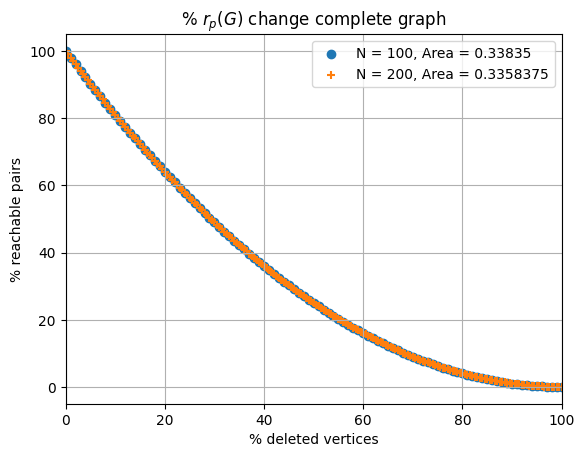

In [ ]:
n_1 = 100
n_2 = 200

rp = lambda V: V * V
area = lambda V: (V * V * V / 3 + V * V / 2 + V / 6) / (V * V * V)
fig, ax = plt.subplots()

percentage_rp = []
percentage_deleted_nodes = []
for k in range(n_1+1):
  percentage_rp.append(rp(n_1-k) / rp(n_1) * 100)
  percentage_deleted_nodes.append(k / n_1 * 100)

ax.scatter(percentage_deleted_nodes, percentage_rp, label = f'N = {n_1}, Area = {area(n_1)}', marker = 'o')
percentage_rp = []
percentage_deleted_nodes = []
for k in range(n_2+1):
  percentage_rp.append(rp(n_2-k) / rp(n_2) * 100)
  percentage_deleted_nodes.append(k / n_2 * 100)

ax.scatter(percentage_deleted_nodes, percentage_rp, label = f'N = {n_2}, Area = {area(n_2)}', marker = '+')

ax.set_xlabel('% deleted vertices')
ax.set_ylabel('% reachable pairs')
ax.set_xlim((0,100))
ax.grid()
ax.legend()
fig.show()
ax.set_title(r'% $r_p(G)$ change complete graph')

Text(0.5, 1.0, '% $r_p(G)$ change complete graph, area evaluation')

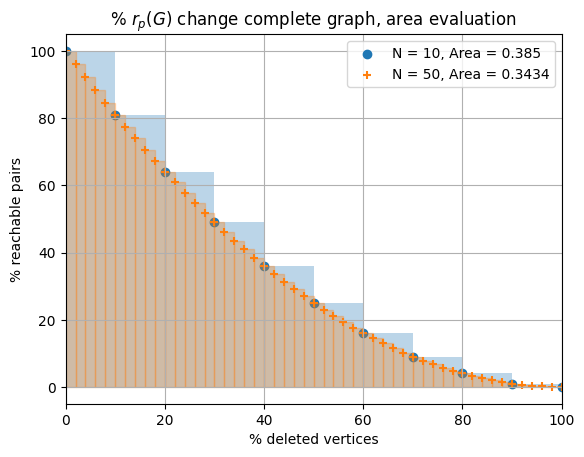

In [ ]:
from matplotlib.patches import Rectangle

n_1 = 10
n_2 = 50

rp = lambda V: V * V
area = lambda V: (V * V * V / 3 + V * V / 2 + V / 6) / (V * V * V)
fig, ax = plt.subplots()

percentage_rp = []
percentage_deleted_nodes = []
for k in range(n_1+1):
  percentage_rp.append(rp(n_1-k) / rp(n_1) * 100)
  percentage_deleted_nodes.append(k / n_1 * 100)

ax.scatter(percentage_deleted_nodes, percentage_rp, label = f'N = {n_1}, Area = {area(n_1)}', marker = 'o')
dx = 1 / n_1 * 100
patches = [Rectangle((x,0),dx,y, alpha = 0.3) for x, y in zip(percentage_deleted_nodes[:-1], percentage_rp[:-1])]
[ax.add_patch(patch) for patch in patches]
percentage_rp = []
percentage_deleted_nodes = []
for k in range(n_2+1):
  percentage_rp.append(rp(n_2-k) / rp(n_2) * 100)
  percentage_deleted_nodes.append(k / n_2 * 100)

ax.scatter(percentage_deleted_nodes, percentage_rp, label = f'N = {n_2}, Area = {area(n_2)}', marker = '+')
dx = 1 / n_2 * 100
patches = [Rectangle((x,0),dx,y, alpha = 0.3, edgecolor = '#ff7f0e', facecolor = '#ff7f0e') for x, y in zip(percentage_deleted_nodes[:-1], percentage_rp[:-1])]
[ax.add_patch(patch) for patch in patches]

ax.set_xlabel('% deleted vertices')
ax.set_ylabel('% reachable pairs')
ax.set_xlim((0,100))
ax.grid()
ax.legend()
fig.show()
ax.set_title(r'% $r_p(G)$ change complete graph, area evaluation')

## Robustness and node sequences evaluation

In [ ]:
#@title Robustness and node sequence

df_robustness_path = '../dataframes/robustness.pickle' #@param {type: "string"}
df_node_sequence_path = '../dataframes/node_sequence.pickle' #@param {type: "string"}
mode = 'load' #@param ['load', 'save']

create_folder(df_robustness_path)
create_folder(df_node_sequence_path)

def get_f_G_removal_node_sequence(G, list_of_removed_nodes):
  graph_name = G['name']
  rows_G = []
  G_temp = G.copy()
  f_G_max = f_G(G_temp)
  V = G.vcount()
  f_G_fully = lambda V: V * (V - 1) * 0.5
  rows_G.append((0, graph_name, 'No nodes removed', f_G_max, 1, f_G_max / f_G_fully(V)))
  for i_node, vertex in enumerate(list_of_removed_nodes):
    G_temp.delete_vertices(vertex)
    node_fraction = (i_node + 1) / V
    f_G_new_norm = f_G(G_temp) / f_G_fully(V - (i_node + 1)) if f_G_fully(V - (i_node + 1)) != 0 else 0.
    rows_G.append((node_fraction, graph_name, vertex, f_G(G_temp), f_G(G_temp) / f_G_max, f_G_new_norm))

  return pd.DataFrame(rows_G, columns=['node_fraction', 'graph_name', 'node_removed', 'f_G_value', 'f_G / f_G_max', 'f_G / f_G_fully'])

def robustness_function(df_node_removal_G):
  values = df_node_removal_G['f_G / f_G_max'].to_numpy()
  N = df_node_removal_G.index[-1]
  return np.sum(values) / N


if mode == 'save':
  df_node_removal = []
  df_robustness = []
  iprog = 0
  out = Progress(len(G_dataset), title_name='Robustness of graph')
  for G in G_dataset:
    graph_name = G['name']
    out.show(iprog, status=graph_name)
    list_of_removed_nodes = node_removal_strategy(G)
    df_node_removal_G = get_f_G_removal_node_sequence(G, list_of_removed_nodes)
    rho_G = robustness_function(df_node_removal_G)
    df_robustness.append((graph_name, rho_G, rho_G_new))
    df_node_removal.append(df_node_removal_G)
    iprog += 1
  df_node_removal = pd.concat(df_node_removal)
  df_robustness = pd.DataFrame(df_robustness, columns = ['graph_name', 'rho_G'])
  order_plot = df_robustness.sort_values(by='rho_G', ascending=False)['graph_name'].to_list()
  df_node_removal['node_fraction'] = df_node_removal['node_fraction'].map(lambda x: x*100)

  df_node_removal.to_pickle(df_node_sequence_path)
  df_robustness.to_pickle(df_robustness_path)
elif mode == 'load':
  df_node_removal = pd.read_pickle(df_node_sequence_path)
  print(f'Node sequence data in {df_node_sequence_path} loaded correctly.')
  df_robustness = pd.read_pickle(df_robustness_path)
  print(f'Robustness data in {df_robustness_path} loaded correctly.')

else:
  print("Mode not implemented...")

Node sequence data in ../dataframes/node_sequence.pickle loaded correctly.
Robustness data in ../dataframes/robustness.pickle loaded correctly.


In [ ]:
#@title Robustness and node sequence with reachable pairs

df_robustness_path = '../dataframes/reachable_pairs_robustness.pickle' #@param {type: "string"}
df_node_sequence_path = '../dataframes/reachable_pairs_node_sequence.pickle' #@param {type: "string"}
mode = 'load' #@param ['load', 'save']

create_folder(df_robustness_path)
create_folder(df_node_sequence_path)

def get_reachable_pairs_change(G, list_of_removed_nodes):
  graph_name = G['name']
  rows_G = []
  G_temp = G.copy()
  V = G.vcount()
  total_pairs = V ** 2

  r_p_G = n_reachable_pairs(G_temp)
  rows_G.append((0, graph_name, 'No nodes removed', r_p_G, r_p_G / total_pairs))
  for i_node, vertex in enumerate(list_of_removed_nodes):
    G_temp.delete_vertices(vertex)
    node_fraction = (i_node + 1) / V
    r_p_G = n_reachable_pairs(G_temp)
    rows_G.append((node_fraction, graph_name, vertex, r_p_G, r_p_G / total_pairs))

  return pd.DataFrame(rows_G, columns=['node_fraction', 'graph_name', 'node_removed', 'n_reachable_pairs', 'percentage_reachable_pairs'])

def robustness_function_reachable_pairs(df_node_removal_G):
  values = df_node_removal_G['percentage_reachable_pairs'].to_numpy()
  N = df_node_removal_G.shape[0]
  return np.sum(values) / N

if mode == 'save':
  df_node_removal = []
  df_robustness = []
  iprog = 0
  out = Progress(len(G_dataset), title_name='Robustness of graph')

  for G in [G_dataset[127]]:
    graph_name = G['name']
    out.show(iprog, status=graph_name)
    list_of_removed_nodes = node_removal_strategy(G, measure_v = lambda G, v: greedy_G_v(G, v, n_reachable_pairs))
    df_node_removal_G = get_reachable_pairs_change(G, list_of_removed_nodes)
    rho_G = robustness_function_reachable_pairs(df_node_removal_G)
    df_robustness.append((graph_name, rho_G))
    df_node_removal.append(df_node_removal_G)
    iprog += 1
    pd.concat(df_node_removal).to_pickle(df_node_sequence_path)
    display(f'Data saved in {df_node_sequence_path}')
    pd.DataFrame(df_robustness, columns = ['graph_name', 'rho_G']).to_pickle(df_robustness_path)
    display(f'Data saved in {df_robustness_path}')

  df_node_removal = pd.concat(df_node_removal)
  df_robustness = pd.DataFrame(df_robustness, columns = ['graph_name', 'rho_G'])
  order_plot = df_robustness.sort_values(by='rho_G', ascending=False)['graph_name'].to_list()
  df_node_removal['node_fraction'] = df_node_removal['node_fraction'].map(lambda x: x*100)

  df_node_removal.to_pickle(df_node_sequence_path)
  df_robustness.to_pickle(df_robustness_path)

elif mode == 'load':
  df_node_removal = pd.read_pickle(df_node_sequence_path)
  print(f'Node sequence data in {df_node_sequence_path} loaded correctly.')
  df_robustness = pd.read_pickle(df_robustness_path)
  print(f'Robustness data in {df_robustness_path} loaded correctly.')

else:
  print("Mode not implemented...")

Node sequence data in ../dataframes/reachable_pairs_node_sequence.pickle loaded correctly.
Robustness data in ../dataframes/reachable_pairs_robustness.pickle loaded correctly.


In [ ]:
df_node_removal.to_pickle('/content/node_sequence.pickle')
df_robustness.to_pickle('/content/robustness.pickle')

In [ ]:
#@title Top 3 critical node (node_sequence is necessary)

df_node_sequence_path = '../dataframes/reachable_pairs_node_sequence.pickle' #@param {type: "string"}
df_node_sequence = pd.read_pickle(df_node_sequence_path)

df_top_critical_nodes_path =  '../dataframes/reachable_pairs_critical_nodes.pickle' #@param {type: "string"}
n_critical_nodes = 3 #@param int
mode = 'load' #@param ['load', 'save']

if mode == 'save':
  create_folder(df_top_critical_nodes_path)
  rows = []
  df_node_sequence = pd.read_pickle(df_node_sequence_path)
  for graph_name in df_node_sequence['graph_name'].unique().tolist():
    df_graph = df_node_sequence[df_node_sequence['graph_name'] == graph_name]
    df_graph = df_graph.iloc[1:n_critical_nodes + 1,:]
    node_sequence = df_graph['node_removed'].tolist()
    rows.append((graph_name, node_sequence))

  columns = ['graph_name', 'node_sequence']
  node_sequence_df = pd.DataFrame(rows, columns = columns)
  node_sequence_df.to_pickle(df_top_critical_nodes_path)
  display(f'Data saved in {df_top_critical_nodes_path}')
elif mode == 'load':
  node_sequence_df = pd.read_pickle(df_top_critical_nodes_path)

else: print('Mode not implemented yet.')

## Metrics comparison

In [ ]:
#@title Robustness comparison and Kendall's tau
import scipy.stats as stats

robustness_fG_df_path = '../dataframes/robustness.pickle' #@param {type: "string"}
robustness_reachable_pairs_df_path = '../dataframes/reachable_pairs_robustness.pickle' #@param {type: "string"}
comparison_df_output_path = '../dataframes/robustness_comparison.pickle' #@param {type: "string"}
mode = 'load' #@param ['load', 'save']

if mode == 'save':
  fg_df = pd.read_pickle(robustness_fG_df_path).set_index(['graph_name'])
  rp_df = pd.read_pickle(robustness_reachable_pairs_df_path).set_index(['graph_name'])

  comparison_df = pd.DataFrame(index = fg_df.index)
  comparison_df['Robustness w/f(G)'] = fg_df['rho_G']
  comparison_df['Robustness w/rp(G)'] = rp_df['rho_G']

  comparison_df.to_pickle(comparison_df_output_path)
  print(f"Data saved in {comparison_df_output_path}.")

elif mode == 'load':
  comparison_df = pd.read_pickle(comparison_df_output_path)
  print(f"Data in {comparison_df_output_path} loaded correctly.")
else:
  print(f"Mode {mode} not implemented yet.")

fg_list = comparison_df.sort_values(by='Robustness w/f(G)', ascending = False).index.to_list()
rp_list = comparison_df.sort_values(by='Robustness w/rp(G)', ascending = False).index.to_list()
tau, p_value = stats.kendalltau(fg_list, rp_list)
print(f'Kendall\'s tau graphs sorted by robustness: {tau} [p value = {p_value}]')

Data in ../dataframes/robustness_comparison.pickle loaded correctly.
Kendall's tau graphs sorted by robustness: 0.013845947035891922 [p value = 0.7868257403885621]


In [ ]:
#@title Critical node Kendall's tau
import scipy.stats as stats

critical_nodes_fG_df_path = '../dataframes/node_sequence.pickle' #@param {type: "string"}
critical_nodes_reachable_pairs_df_path = '../dataframes/reachable_pairs_node_sequence.pickle' #@param {type: "string"}
comparison_df_output_path = '../dataframes/critical_node_list_kendall_tau.pickle' #@param {type: "string"}
mode = 'load' #@param ['load', 'save']

if mode == 'save':
  fG_df = pd.read_pickle(critical_nodes_fG_df_path)
  rp_df = pd.read_pickle(critical_nodes_reachable_pairs_df_path)

  unique_graphs_fG = fG_df['graph_name'].unique()
  unique_graphs_rp = rp_df['graph_name'].unique()

  if (unique_graphs_fG == unique_graphs_rp).all():
    unique_graphs = unique_graphs_fG
  else:
    raise Exception("Critcal nodes list contains different graphs.")
  rows = []
  for graph_name in unique_graphs:
    node_list_fG = fG_df[fG_df['graph_name'] == graph_name]['node_removed'].to_list()[1:]
    node_list_rp = rp_df[rp_df['graph_name'] == graph_name]['node_removed'].to_list()[1:]
    tau, p_value = stats.kendalltau(node_list_fG, node_list_rp)

    rows.append((graph_name, tau, p_value))

  df = pd.DataFrame(rows, columns=['Graph', 'Kendall\'s tau', 'p value']).to_pickle(comparison_df_output_path)
  print(f'Data saved in {comparison_df_output_path}.')
elif mode == 'load':
  df = pd.read_pickle(comparison_df_output_path)
  display(df)
  print(f'Data in {comparison_df_output_path} loaded correctly.')

else:
  print(f'Mode {mode} not implemented yet.')

,Graph,Kendall's tau,p value
0,Lower Chesapeake Bay,-0.107692,4.574399e-01
1,Middle Chesapeake Bay,0.669951,2.507695e-08
2,Upper Chesapeake Bay,-0.117241,3.755463e-01
3,Chesapeake Bay Mesohaline,-0.049242,7.007202e-01
4,Crystal River Creek - Control,0.810526,9.061085e-09
...,...,...,...
168,Western Channel (1993),0.405714,3.219826e-05
169,Western Tropical Pacific Ocean (1990),0.321637,5.806025e-02
170,"Ythan estuary, Aberdeenshire, Scotland",0.170218,3.661171e-03
171,Yucatan (1987),0.105263,5.424221e-01


Data in ../dataframes/critical_node_list_kendall_tau.pickle loaded correctly.


# 3 Motifs representation

In [ ]:
#@title Utility functions

from random import sample
from collections import OrderedDict
from itertools import combinations

def is_valid_edge_swap(single_edge_list, double_edge_list, edge_1, edge_2):
  A, B = edge_1
  C, D = edge_2

  # self loops?
  if A == B or C == D:
    return False

  # will I create a self loop?
  if A == D or B == C:
    return False
  # are the new edges in the list?
  if ([A,D] in single_edge_list) or ([D,A] in single_edge_list) or ([A,D] in double_edge_list) or ([D,A] in double_edge_list):
    return False

  # are the new edges in the list?
  if ([C,B] in single_edge_list) or ([B,C] in single_edge_list) or ([C,B] in double_edge_list) or ([B,C] in double_edge_list):
    return False

  return True

def get_edge_lists(G):
  edge_list = []
  for e in G.es():
    edge_list.append([e.source, e.target])

  single_edge_list = []
  double_edge_list = []
  for e in G.es():
    source = e.source
    target = e.target
    if source == target: continue # skip self-loops
    if [target, source] in edge_list:
      if [target, source] not in double_edge_list: double_edge_list.append([source, target])
    else:
      single_edge_list.append([source, target])

  return single_edge_list, double_edge_list

def swap_G_v2(G):
  single_edge_list, double_edge_list = get_edge_lists(G)
  n_single_edge = len(single_edge_list)
  n_double_edge = len(double_edge_list)

  if n_single_edge >= 2:
    for n in range(100*n_single_edge):
      iA, iB = sample(range(n_single_edge), 2)
      if is_valid_edge_swap(single_edge_list, double_edge_list, single_edge_list[iA], single_edge_list[iB]) is False: continue
      A, B = single_edge_list[iA]
      C, D = single_edge_list[iB]
      #swap
      single_edge_list[iA][1] = D
      single_edge_list[iB][1] = B

  if n_double_edge >= 2:
    for n in range(100*n_double_edge):
      iA, iB = sample(range(n_double_edge), 2)
      if is_valid_edge_swap(single_edge_list, double_edge_list, double_edge_list[iA], double_edge_list[iB]) is False: continue
      A, B = double_edge_list[iA]
      C, D = double_edge_list[iB]
      #swap
      double_edge_list[iA][1] = D
      double_edge_list[iB][1] = B

  edge_list_swap = [[edge[0], edge[1]] for edge in single_edge_list] + [[edge[0], edge[1]] for edge in double_edge_list] + [[edge[1], edge[0]] for edge in double_edge_list]

  S = G.vcount()
  G_swap = ig.Graph(n=S, edges=edge_list_swap, directed=True)
  return G_swap

def motif_contained_in_G_fast(G):
  igraph_to_nx_translate = {'021C': 'S1',
                            '030T': 'S2',
                            '030C': 'S3',
                            '021U': 'S4',
                            '021D': 'S5',
                            '120U': 'D1',
                            '120D': 'D2',
                            '111U': 'D3',
                            '111D': 'D4',
                            '120C': 'D5',
                            '300': 'D6',
                            '210': 'D7',
                            '201': 'D8'}

  motif_count = {}
  triads = G.triad_census()
  for igraph_motif in igraph_to_nx_translate:
    nx_motif_label = igraph_to_nx_translate[igraph_motif]
    motif_count[nx_motif_label] = triads[igraph_motif]

  return motif_count

def process_row(i):
    row_tc_G_swap = []
    h_c_swap = motif_contained_in_G_fast(swap_G_v2(G))
    row_tc_G_swap.append(f"{i:03d}")
    row_tc_G_swap.append(G['name'])
    for motif in motifs_name:
        row_tc_G_swap.append(h_c_swap[motif])

    return tuple(row_tc_G_swap)

def load_motifs():

  H = OrderedDict({
        "S1": ig.Graph(n = 3, edges = [[0,1], [1,2]], directed = True),                                     # Foodchain
        "S2": ig.Graph(n = 3, edges = [[0,1], [2,0], [2,1]], directed = True),                              # Omnivory
        "S3": ig.Graph(n = 3, edges = [[0,1], [1,2], [2,0]], directed = True),                              # Autocatalisys
        "S4": ig.Graph(n = 3, edges = [[0,1], [2,1]], directed = True),                                     # Direct Competition
        "S5": ig.Graph(n = 3, edges = [[1,0], [1,2]], directed = True),                                     # Apparent Competition
        "D1": ig.Graph(n = 3, edges = [[0,1], [1,0], [0,2], [1,2]], directed = True),
        "D2": ig.Graph(n = 3, edges = [[0,1], [1,0], [2,1], [2,0]], directed = True),
        "D3": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2]], directed = True),
        "D4": ig.Graph(n = 3, edges = [[0,1], [1,0], [2,0]], directed = True),
        "D5": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2], [2,0]], directed = True),
        "D6": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2], [2,1], [0,2], [2,0]], directed = True),
        "D7": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2], [2,1], [0,2]], directed = True),
        "D8": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2], [2,1]], directed = True)
               })
  for motif in list(H.keys()):
    H[motif].vs()['name'] = [1,2,3]
    H[motif].vs()['ECO'] = [4,4,4]

  return H

def generate_tuples(indices, tuple_length):
    # Use combinations to generate tuples of the specified length
    result = list(combinations(indices, tuple_length))
    return result

def get_node_roles_in_triads(G):
  graph_name = G['name']
  taxa_indices = [v.index for v in G.vs]
  triads = generate_tuples(taxa_indices, 3)
  motifs_dataset = load_motifs()

  # Deleting loops
  edges_no_loops = [(e.source, e.target) for e in G.es if e.source != e.target]
  G_exp = ig.Graph(n = G.vcount(), edges = edges_no_loops, directed=True)
  G_exp.vs['name'] = G.vs['name']
  G_exp.vs['ECO'] = G.vs['ECO']

  rows = []
  for triad in triads:
    G_sub = G_exp.subgraph(triad)
    for motif_name, h in motifs_dataset.items():
      if h.isomorphic(G_sub):
        for sub_id, node_id in enumerate(triad):
          if motif_name == 'S1':
            if G_sub.vs[sub_id].outdegree() == 1 and G_sub.vs[sub_id].indegree() == 1: role = 'middle'
            elif G_sub.vs[sub_id].outdegree() == 1: role = 'bottom'
            elif G_sub.vs[sub_id].indegree() == 1: role = 'top'
            else: print('Are you ok,', motif_name, '?')
          elif motif_name == 'S2':
            if G_sub.vs[sub_id].outdegree() == 2: role = 'bottom'
            elif G_sub.vs[sub_id].outdegree() == 1 and G_sub.vs[sub_id].indegree() == 1: role = 'middle'
            elif G_sub.vs[sub_id].outdegree() == 0: role = 'top'
            else: print('Are you ok,', motif_name, '?')
          elif motif_name == 'S4':
            if G_sub.vs[sub_id].indegree() == 2: role = 'top'
            elif G_sub.vs[sub_id].outdegree() == 1: role = 'bottom'
            else: print('Are you ok,', motif_name, '?')
          elif motif_name == 'S5':
            if G_sub.vs[sub_id].outdegree() == 2: role = 'bottom'
            elif G_sub.vs[sub_id].indegree() == 1: role = 'top'
            else: print('Are you ok,', motif_name, '?')
          else: role = 'none'
          name = G_sub.vs[sub_id]['name']
          row = (graph_name, node_id, name, motif_name, role)
          rows.append(row)

  columns = ['graph_name', 'node_id', 'node_name', 'motif_name', 'role']
  return pd.DataFrame(rows, columns = columns)

In [ ]:
#@title Living organism dataset

G_living_compartment_dataset = []
for G in G_dataset:
  v_sub = [v for v in G.vs() if v['ECO'] == 1]
  G_living_compartment_dataset.append(G.subgraph(v_sub))

In [ ]:
#@title Roles of each node given the triad

df_motif_living_filepath = '../dataframes/taxa_role.pickle'  #@param {type:'string'}
df_motif_all_filepath = '../dataframes/all_compartments_role.pickle'  #@param {type:'string'}
mode = 'load'                                            #@param ['save', 'load']

if mode == 'load':
  df_motif_living = pd.read_pickle(df_motif_living_filepath)
  df_motif_all = pd.read_pickle(df_motif_all_filepath)
  display('Data loaded correctly.')

if mode == 'save':
  out1 = Progress(title_name='Graph', max = len(G_dataset))
  create_folder(df_motif_living_filepath)
  create_folder(df_motif_all_filepath)
  # for mode in ['all', 'living']:
  for mode in ['living']:
    G_dataset_experiments = G_dataset if mode == 'all' else G_living_compartment_dataset
    dataframe_save_path = df_motif_all_filepath if mode =='all' else df_motif_living_filepath
    df_save = None
    for g, G in enumerate(G_dataset_experiments):
      out1.show(g+1, status = f"{G['name']} V={G.vcount()} E={G.ecount()}\n{g+1:2d}/{out1.max:2d}")
      df = get_node_roles_in_triads(G)
      if df_save is None:
        df_save = df.copy()
      else:
        df_save = pd.concat([df_save, df])
      df_save.to_pickle(dataframe_save_path)
    display(f'File saved in {dataframe_save_path}')

'Data loaded correctly.'

In [ ]:
#@title Make datasets: triads census of real networks {display-mode: "form"}
df_folder = '../dataframes/' #@param {type: "string"}
df_real_tc_filename_all = 'real_networks_triad_census_all.pickle' #@param {type: "string"}
df_real_tc_filename_living = 'real_networks_triad_census_living.pickle' #@param {type: "string"}

mode = 'load' #@param ['load', 'save']

if mode == 'load':
  df_real_tc_all = pd.read_pickle(os.path.join(df_folder, df_real_tc_filename_all))
  df_real_tc_living = pd.read_pickle(os.path.join(df_folder,df_real_tc_filename_living ))
  display('Data loaded correctly.')

elif mode == 'save':
  motifs_dict = load_motifs()
  available_graph_names = []
  out1 = Progress(title_name='Graph', max = len(G_dataset))
  for graph_type in ['all', 'living']:
  # for graph_type in ['living']:
    rows = []
    G_dataset_experiments = G_dataset if graph_type == 'all' else G_living_compartment_dataset
    data_path = os.path.join(df_folder, df_real_tc_filename_all) if graph_type == 'all' else  os.path.join(df_folder, df_real_tc_filename_living)
    create_folder(data_path)

    for g, G in enumerate(G_dataset_experiments):
      graph_name = G['name']
      out1.show(g+1, status = f"{G['name']} V={G.vcount()} E={G.ecount()}\n{g+1:2d}/{out1.max:2d}")

      row = []
      row.append(graph_name)
      available_graph_names.append(graph_name)
      for _, item in motif_contained_in_G_fast(G).items():
        row.append(item)

      rows.append(tuple(row))

    df_real_tc = pd.DataFrame(rows, columns = ['graph_name'] + [key for key in motifs_dict])
    df_real_tc.to_pickle(data_path)
    display(f'{graph_type}: Data saved in {data_path}')
else:
  display(f'Mode {mode} not implemented yet')

'Data loaded correctly.'

In [ ]:
#@title Triad census - Swap randomization {display-mode: "form"}
import multiprocessing
G_motif_dataset_er = {}
N = 50 #@param
df_out_folder = '../dataframes/' #@param {type: "string"}
df_swap_all_filename = 'swap_all.pickle' #@param {type: "string"}
df_swap_living_filename = 'swap_living.pickle' #@param {type: "string"}

mode = 'load' #@param ['load', 'save']

if mode == 'load':
  df_swap_all_tc = pd.read_pickle(os.path.join(df_out_folder, df_swap_all_filename))
  df_swap_living_tc = pd.read_pickle(os.path.join(df_out_folder, df_swap_living_filename))
  display('Data loaded correctly.')

elif mode == 'save':
  # Define the number of processes to use

  motifs_name = list(load_motifs().keys())

  for graph_type in ['all', 'living']:
    G_dataset_experiments = G_dataset if graph_type == 'all' else G_living_compartment_dataset
    df_swap_filename = df_swap_all_filename if graph_type == 'all' else df_swap_living_filename
    data_path = os.path.join(df_out_folder, df_swap_filename)
    create_folder(data_path)

    num_processes = multiprocessing.cpu_count()
    rows_tc_G_swap = []
    out1 = Progress(title_name='Graph', max = len(G_dataset_experiments))
    out3 = display('', display_id=True)

    for g, G in enumerate(G_dataset_experiments):
      pool = multiprocessing.Pool(4)
      out1.show(g+1, status = f"{G['name']} V={G.vcount()} E={G.ecount()}\n{g+1:2d}/{out1.max:2d}")
      # Map the loop range to the worker processes
      rows = pool.map(process_row, range(N))
      for row in rows:
        rows_tc_G_swap.append(row)
      df_swap_tc = pd.DataFrame(rows_tc_G_swap, columns = ['id', 'graph_name'] + [motif for motif in motifs_name])
      df_swap_tc.to_pickle(data_path)
      # Close the pool and wait for all processes to finish
      pool.close()
      pool.join()

      out3.update(f"{graph_type}: Saved experiment of {G['name']} in {data_path}")
else:
  display(f'Mode {mode} not implemented yet.')

'Data loaded correctly.'

In [ ]:
#@title Z-score

df_folder = '../dataframes/'             #@param {type:"string"}
df_tc_z_score_filename_all = 'z_score_swap_all.pickle'             #@param {type:"string"}
df_tc_z_score_filename_living = 'z_score_swap_living.pickle'             #@param {type:"string"}
mode = 'load'                                            #@param ['save', 'load']
df_random_tc_all_path = '../dataframes/swap_all.pickle' #@param {type:"string"}
df_random_tc_living_path = '../dataframes/swap_living.pickle' #@param {type:"string"}
df_real_tc_all_path = '../dataframes/real_networks_triad_census_all.pickle' #@param {type:"string"}
df_real_tc_living_path = '../dataframes/real_networks_triad_census_living.pickle' #@param {type:"string"}

if mode == 'load':
  df_tc_z_score_er_all = pd.read_pickle(os.path.join(df_folder, df_tc_z_score_filename_all))
  df_tc_z_score_er_living = pd.read_pickle(os.path.join(df_folder,df_tc_z_score_filename_living ))
  display('Data loaded correctly.')
elif mode == 'save':

  available_graphs = [G['name'] for G in G_dataset]
  # nicknames = [G_dataset[index_from_dataset(G_dataset, name)]['nickname'] for name in available_graphs]
  for graph_type in ['all', 'living']:
    out_path = os.path.join(df_folder, df_tc_z_score_filename_all) if graph_type == 'all' else os.path.join(df_folder, df_tc_z_score_filename_living)
    series = []
    df_random_tc = pd.read_pickle(df_random_tc_all_path) if graph_type == 'all' else pd.read_pickle(df_random_tc_living_path)
    df_real_tc = pd.read_pickle(df_real_tc_all_path) if graph_type == 'all' else pd.read_pickle(df_real_tc_living_path)
    for graph_name in available_graphs:
      df_temp = df_random_tc[df_random_tc['graph_name'] == graph_name].iloc[:,2:]
      N_real = df_real_tc[df_real_tc['graph_name'] == graph_name].iloc[0,1:]
      mean_N_er = df_temp.mean()
      sigma_N_er = df_temp.std()
      series.append((N_real - mean_N_er) / sigma_N_er)  # cfr. eq (2.1) - Stouffer 2007

    del(df_temp)
    df_tc_z_score = pd.DataFrame(series)
    df_tc_z_score.insert(0, 'graph_name', available_graphs)
    # df_tc_z_score.insert(1, 'nickname', nicknames)
    df_tc_z_score.fillna(0, inplace=True)
    df_tc_z_score.to_pickle(out_path)
    display(f'Data saved in {out_path}')
else:
  display('Mode not implemented yet.')
# Stouffer, D. B., Camacho, J., Jiang, W., & Nunes Amaral, L. A. "Evidence for the existence of a robust pattern of prey selection in food webs."
# Proceedings of the Royal Society B: Biological Sciences 274.1621 (2007): 1931-1940.

'Data loaded correctly.'

In [ ]:
pd.read_pickle(df_real_tc_living_path).to_pickle('/content/real_networks_triad_census_living.pickle')
pd.read_pickle(df_random_tc_living_path).to_pickle('/content/swapped_triad_census_living.pickle')

# Visualization

## Utility functions

In [ ]:
import matplotlib.patches as mpatches

def visual_style(g, color_attribute = 'ECO', vertex_label_attribute = 'name', layout=None, size_mode=None):
  # set layout
  if layout is None:
    layout = g.layout_fruchterman_reingold(niter=1000)

  # these properties will be used to set the graph aspect
  try:
    weights = [e['weight'] for e in g.es()]
  except:
    weights = [1.0 for e in g.es()]

  visual_style = {}
  # set visual style
  visual_style = {}
  ## set vertex labels to be the name of the vertex of the graph
  if vertex_label_attribute is not None: visual_style['vertex_label'] = [v[vertex_label_attribute] for v in g.vs()]
  ## change label size according to the betweenness
  visual_style['vertex_size'] = 30
  ## change color according to the vertex color_attribute property

  if color_attribute is not None:
    palette = {
    0: '#1f77b4',
    1: '#ff7f0e',
    2: '#aec7e8',
    3: '#ffbb78',
    4: '#2ca02c',
    5: '#98df8a',
    6: '#d62728',
    7: '#ff9896',
    8: '#9467bd',
    9: '#c5b0d5',
    10: '#8c564b',
    11: '#c49c94',
    12: '#e377c2',
    13: '#f7b6d2',
    14: '#7f7f7f',
    15: '#c7c7c7',
    16: '#bcbd22',
    17: '#dbdb8d',
    18: '#17becf',
    19: '#9edae5'
    }

    n_palette = len(palette.keys())
    unique_attributes_color = set([v[color_attribute] for v in g.vs()])
    index_to_attribute = {attribute: index % n_palette for index, attribute in zip(range(len(unique_attributes_color)), unique_attributes_color)}

    visual_style['vertex_color'] = [palette[index_to_attribute[v[color_attribute]]] for v in g.vs()]
  else:
    visual_style['vertex_color'] = ['#1f77b4' for v in g.vs()]
  ## change the width of the verteces
  visual_style['vertex_frame_width'] = 1


  ## set edge color to be gray. The higher the weight of the lower the transparancy
  visual_style['edge_color'] = [(0.5, 0.5, 0.5, 1) for w in weights]
  ## change edge width
  visual_style['edge_width'] = 0.1


  ## change vertex labels' size
  visual_style['vertex_label_size'] = 10

  ## set the layout into the dictionary
  visual_style['layout'] = layout

  return visual_style

def ego_net(G, node, neighbor_order = 1, mode='all'):
  if type(node) == str:
    if node in G.vs['name'] is False:
      print(f'Node {node} not found. Aborting.')
      return False
    for v in G.vs:
      if node == v['name']: node = v
  elif type(node) == int:
    if node in [v.index for v in G.vs] is False:
      print(f'Node {node} not found. Aborting.')
      return False
    for v in G.vs:
      if node == v.index: node = v
  elif type(node) == ig.Vertex:
    if node in [v for v in G.vs] is False:
      print(f'Node {node} not found. Aborting.')
      return False
      node = v
  else:
    print('Node should be either a string, an integer or a ig.Vertex.')
    return False

  neighborhood = G.neighborhood(node, order = neighbor_order, mode = mode)
  v_subgraph = [node.index] + neighborhood
  G_sub = G.subgraph(v_subgraph)
  vs = visual_style(G_sub)
  vs['vertex_shape'] = ['circle' for _ in range(len(v_subgraph))]
  return G_sub, vs

def plot_graph(G, color_attribute = 'ECO', vertex_label_attribute = 'name', target = None):
    print(color_attribute)
    vs = visual_style(G, color_attribute = color_attribute, vertex_label_attribute = vertex_label_attribute)
    if target is None:
        fig, ax = plt.subplots()
    else:
        ax = target
        fig = ax.get_figure()

    ig.plot(G, target = ax, **vs)

    # Setting the handles
    color_label = set()
    labels = G.vs[color_attribute]
    colors = vs['vertex_color']
    for color, label in zip(colors, labels):
        color_label.add((color, f'{color_attribute}: {label}'))

    handles = [mpatches.Circle((0.5, 0.5), 0.5, facecolor = color, label = label) for color, label in color_label]
    handles = handles + [mpatches.Circle((0.0, 0.0), 0.0, color = 'white')]
    ax.legend(handles = handles, bbox_to_anchor=(1.0, 0.05))
    return fig, ax

## Core/Periphery

In [ ]:
network_bowtie_df_path = '../dataframes/core_and_periphery_dataframe.pickle' #@param {type: "string"}

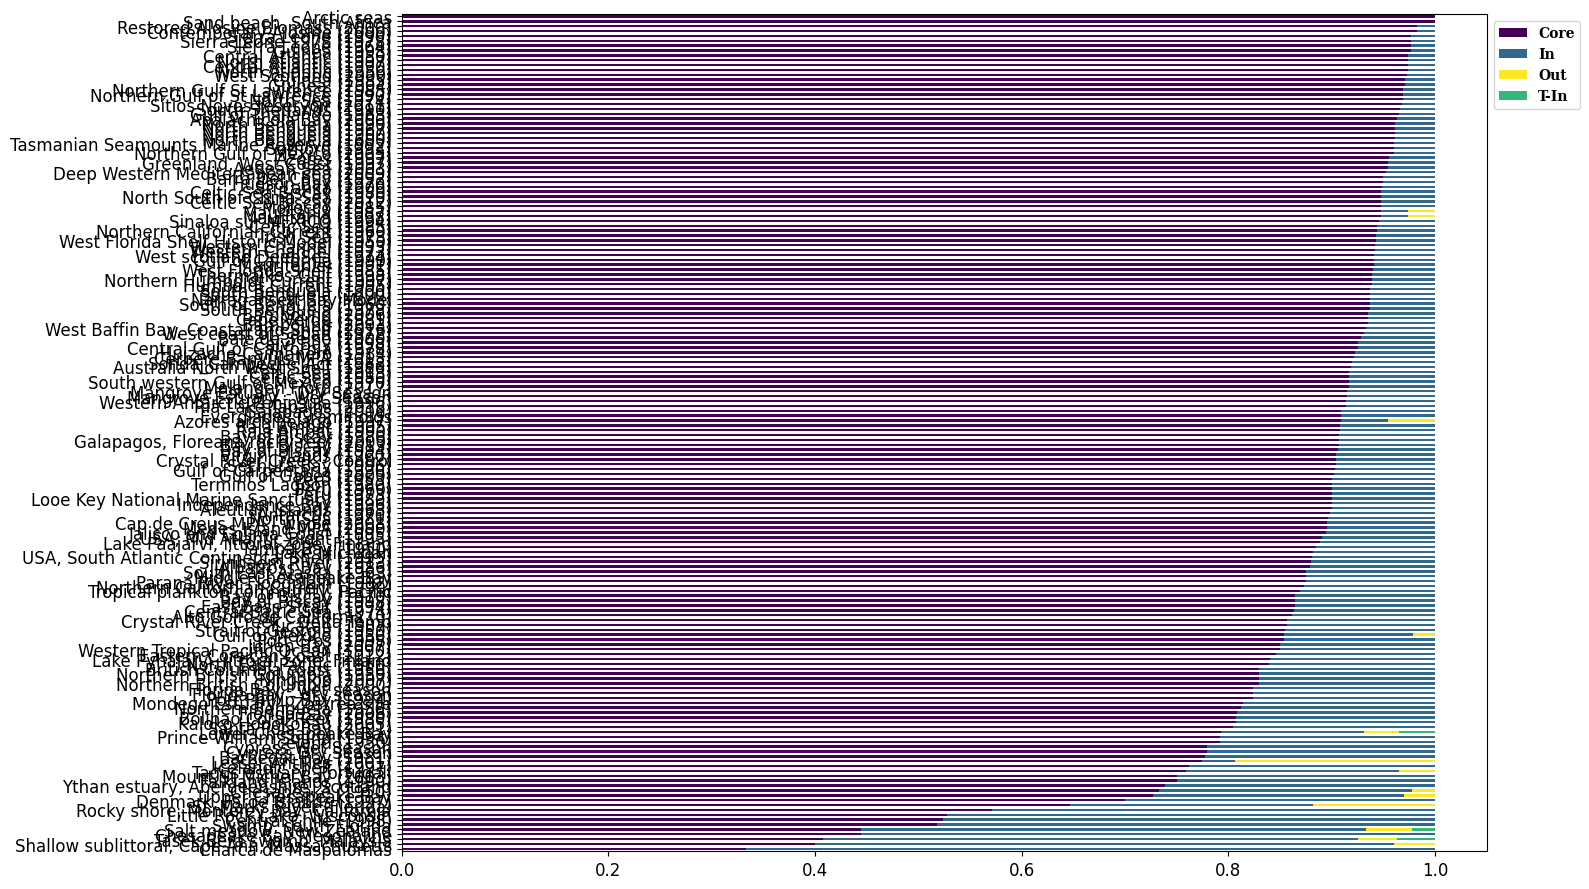

In [ ]:
#@title Periphery analysis
image_out_path = '../images/periphery_structure_1_messy.pdf' #@param {type: "string"}
create_folder(image_out_path)

# Get the vibrant color palette
cmap = plt.cm.viridis

# Reverse the order of colors
cmap_rev = cmap(np.linspace(0, 1, 4))
temp = cmap_rev[2].copy()
cmap_rev[2] = cmap_rev[3]
cmap_rev[3] = temp

font = {
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
plot_periphery_df = network_bowtie_df.drop(['T-out', 'Tubes', 'Disconnected'], axis=1)

fig, ax = plt.subplots(figsize=(11.7 ,8.3))
plot_periphery_df.sort_values(by='Core', ascending = True).plot(
    kind = 'barh',
    stacked = True,
    layout='constrained',
    ax=ax,
    color=cmap_rev,
    figsize=(16,9)
)

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

ax.legend(bbox_to_anchor=(1,1))
fig.tight_layout()
fig.savefig(image_out_path)

In [ ]:
network_bowtie_df

,Core,In,Out,T-In,T-out,Tubes,Disconnected
Lower Chesapeake Bay,0.793103,0.137931,0.034483,0.034483,0.0,0.0,0.0
Middle Chesapeake Bay,0.875000,0.125000,0.000000,0.000000,0.0,0.0,0.0
Upper Chesapeake Bay,0.727273,0.242424,0.030303,0.000000,0.0,0.0,0.0
Chesapeake Bay Mesohaline,0.444444,0.555556,0.000000,0.000000,0.0,0.0,0.0
Crystal River Creek - Control,0.904762,0.095238,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...
Western Channel (1973),0.942308,0.057692,0.000000,0.000000,0.0,0.0,0.0
Western Channel (1993),0.942308,0.057692,0.000000,0.000000,0.0,0.0,0.0
Western Tropical Pacific Ocean (1990),0.850000,0.150000,0.000000,0.000000,0.0,0.0,0.0
"Ythan estuary, Aberdeenshire, Scotland",0.738806,0.261194,0.000000,0.000000,0.0,0.0,0.0


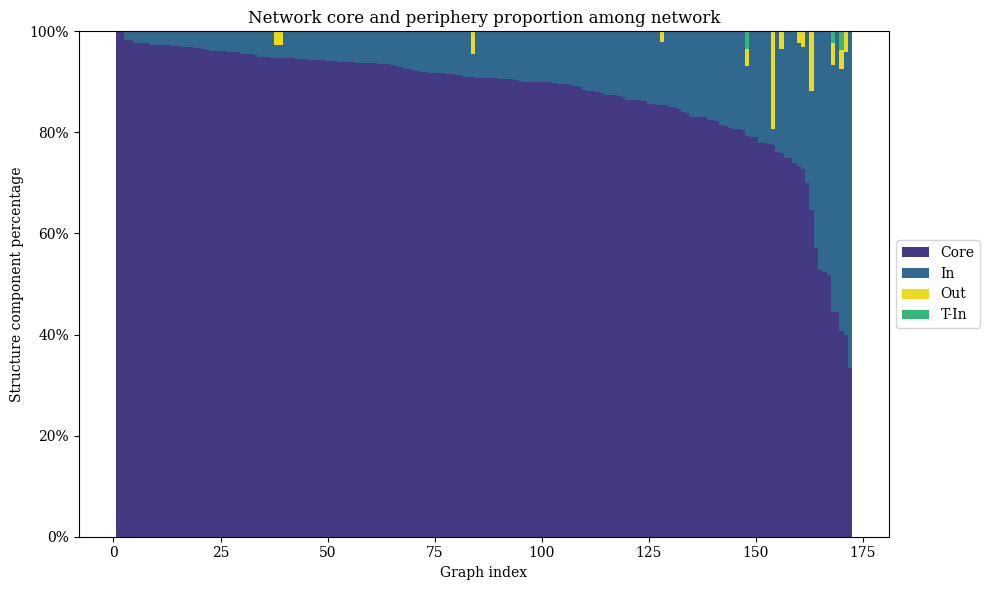

In [ ]:
#@title Periphery distribution
image_out_path = '/content/core_periphery_results.eps' #@param {type: "string"}
create_folder(image_out_path)

N_graph = len(G_dataset)

graph_name_index = range(1,N_graph)
plot_periphery_df = network_bowtie_df.sort_values(by='Core', ascending=False)
N_graph = plot_periphery_df.shape[0]
core_per_proportions = {col: plot_periphery_df[col].values * 100 for col in ['Core', 'In', 'Out', 'T-In']}

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize = (10,6))

width_bar_x = 1
bottom = np.zeros(N_graph)
colors = sns.color_palette("viridis", as_cmap=False, n_colors=5)
colors[2] = (0.926579, 0.854645, 0.123353)
# colors[3] = colors[-1]
icolor = 0
for boolean, weight_count in core_per_proportions.items():
    p = ax.bar(graph_name_index, weight_count, width_bar_x, label=boolean, bottom=bottom, color=colors[icolor], edgecolor='none', rasterized=True)
    bottom += weight_count
    icolor += 1

ax.set_title("Network core and periphery proportion among network")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Graph index')
ax.set_ylabel('Structure component percentage')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()
fig.savefig(image_out_path, format='eps')
fig.show()


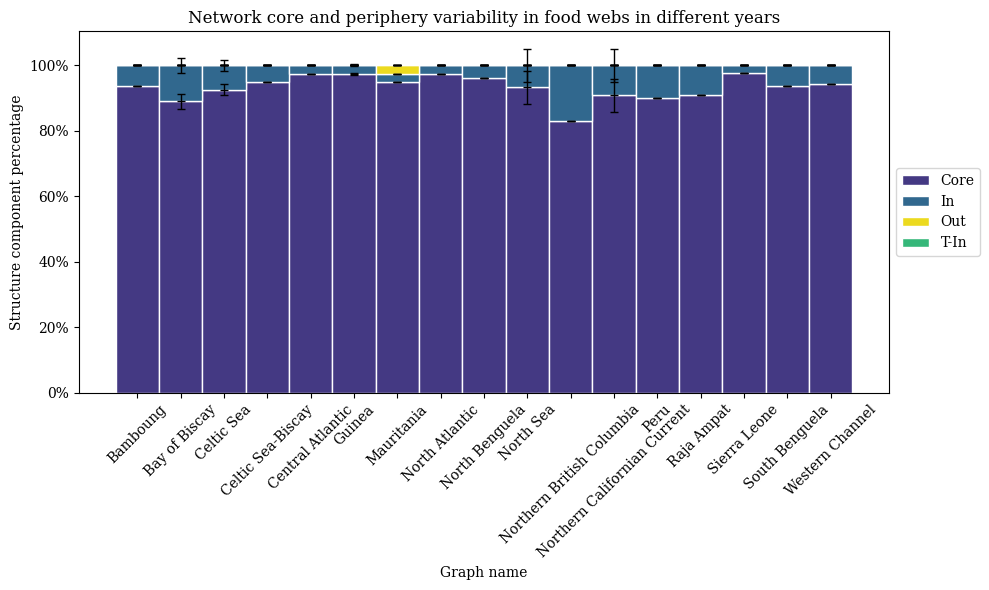

In [ ]:
#@title Periphery distribution of same habitats foodwebs
import re
def remove_year(name):
    pattern = r'\(\d{4}\)'
    return re.sub(pattern, '', name).strip()

image_out_path = '/content/core_periphery_same_habitat.eps' #@param {type: "string"}
create_folder(image_out_path)

original_names = network_bowtie_df.reset_index(names = 'Graph Name')['Graph Name'].tolist()
strip_names = [remove_year(name) for name in original_names]
index_dict = {}
for index, name in enumerate(strip_names):
    if name in index_dict:
        # Append the index to the existing list for this name
        index_dict[name].append(index)
    else:
        # Create a new list with the current index for this name
        index_dict[name] = [index]

index_dict = {key: item for key, item in index_dict.items() if len(item) > 1}
# Initialize an empty list to store the merged result
indices = []

# Iterate over the dictionary and extend the merged list with each value
for value in index_dict.values():
    indices.extend(value)

season_core_periphery_df = network_bowtie_df.reset_index(names = 'Graph Name')
season_core_periphery_df['Graph Name'] = strip_names
plot_periphery_df = season_core_periphery_df.iloc[indices,:].groupby('Graph Name').mean()
std_periphery_df = season_core_periphery_df.iloc[indices,:].groupby('Graph Name').std()
N_graph = plot_periphery_df.shape[0]
graph_name_index = plot_periphery_df.index.to_list()
core_per_proportions = {col: plot_periphery_df[col].values * 100 for col in ['Core', 'In', 'Out', 'T-In']}

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize = (10,6))

width_bar_x = 1
bottom = np.zeros(N_graph)
colors = sns.color_palette("viridis", as_cmap=False, n_colors=5)
colors[2] = (0.926579, 0.854645, 0.123353)
# colors[3] = colors[-1]
icolor = 0
for boolean, weight_count in core_per_proportions.items():
    p = ax.bar(graph_name_index, weight_count, width_bar_x, label=boolean, bottom=bottom, color=colors[icolor], edgecolor='white', rasterized=True)
    bottom += weight_count
    icolor += 1

for col in ['Core', 'In', 'Out', 'T-In']:
    # Calculate the cumulative sum for positioning the STD line correctly
    cumulative_sum = np.cumsum([core_per_proportions.get(c, np.zeros(N_graph)) for c in ['Core', 'In', 'Out', 'T-In']], axis=0)
    # Get the current height for each bar to position the STD line
    current_height = cumulative_sum[list(core_per_proportions.keys()).index(col)]
    # Plot the STD line
    ax.errorbar(graph_name_index, current_height, yerr=std_periphery_df[col].values * 100, fmt='k_', ecolor='black', elinewidth=1, capsize=3)

ax.set_title("Network core and periphery variability in food webs in different years")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Graph name')
ax.set_ylabel('Structure component percentage')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=45)

fig.tight_layout()
fig.savefig(image_out_path, format='eps')
fig.show()


In [ ]:

# Apply the function to each name in the list

original_names = network_bowtie_df.reset_index(names = 'Graph Name')['Graph Name'].tolist()
strip_names = [remove_year(name) for name in original_names]
index_dict = {}
for index, name in enumerate(strip_names):
    if name in index_dict:
        # Append the index to the existing list for this name
        index_dict[name].append(index)
    else:
        # Create a new list with the current index for this name
        index_dict[name] = [index]

index_dict = {key: item for key, item in index_dict.items() if len(item) > 1}
# Initialize an empty list to store the merged result
indices = []

# Iterate over the dictionary and extend the merged list with each value
for value in index_dict.values():
    indices.extend(value)

season_core_periphery_df = network_bowtie_df.reset_index(names = 'Graph Name')
season_core_periphery_df['Graph Name'] = strip_names
season_core_periphery_df.iloc[indices,:].groupby('Graph Name').mean()

,Core,In,Out,T-In,T-out,Tubes,Disconnected
Graph Name,,,,,,,
Bamboung,0.935484,0.064516,0.000000,0.0,0.0,0.0,0.0
Bay of Biscay,0.889987,0.110013,0.000000,0.0,0.0,0.0,0.0
Celtic Sea,0.925926,0.074074,0.000000,0.0,0.0,0.0,0.0
Celtic Sea-Biscay,0.947368,0.052632,0.000000,0.0,0.0,0.0,0.0
Central Atlantic,0.973684,0.026316,0.000000,0.0,0.0,0.0,0.0
Guinea,0.973377,0.026623,0.000000,0.0,0.0,0.0,0.0
Mauritania,0.947368,0.026316,0.026316,0.0,0.0,0.0,0.0
North Atlantic,0.973684,0.026316,0.000000,0.0,0.0,0.0,0.0
North Benguela,0.961538,0.038462,0.000000,0.0,0.0,0.0,0.0


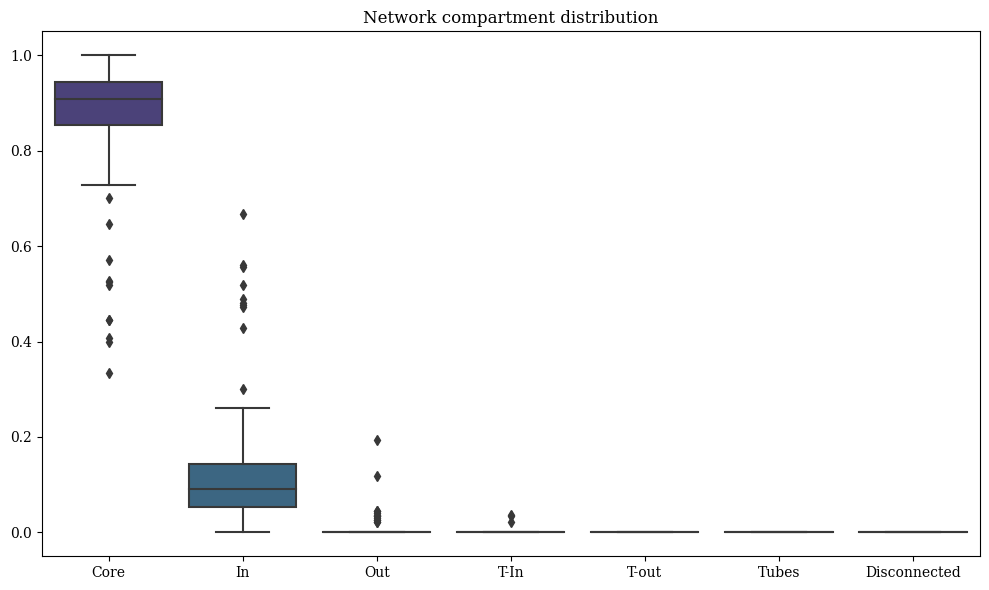

In [ ]:
#@title Periphery distribution
image_out_path = '../images/periphery_structure_distribution_2.pdf' #@param {type: "string"}
create_folder(image_out_path)

plot_periphery_df = network_bowtie_df.sort_values(by='Core', ascending=False)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize = (10,6))
colors = sns.color_palette("viridis", as_cmap=False, n_colors=5)
colors[2] = (0.926579, 0.854645, 0.123353)

sns.boxplot(plot_periphery_df, palette = colors)
ax.set_title("Network compartment distribution")

fig.tight_layout()
fig.savefig(image_out_path)
fig.show()


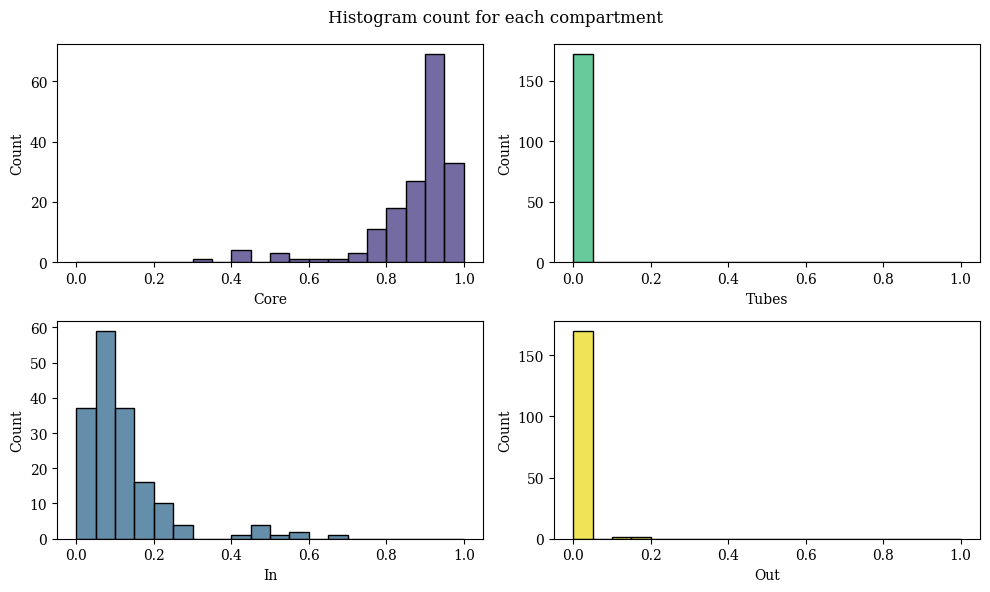

In [ ]:
#@title Periphery distribution
image_out_path = '../images/periphery_structure_distribution_3.pdf' #@param {type: "string"}
create_folder(image_out_path)

plot_periphery_df = network_bowtie_df.sort_values(by='Core', ascending=False)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(2,2, figsize = (10,6))
bins = np.linspace(0,1,21)
colors = sns.color_palette("viridis", as_cmap=False, n_colors=5)
colors[2] = (0.926579, 0.854645, 0.123353)

sns.histplot(plot_periphery_df['Core'], ax = axs[0,0], bins=bins, color=colors[0])
sns.histplot(plot_periphery_df['Tubes'], ax = axs[0,1], bins=bins, color=colors[3])
sns.histplot(plot_periphery_df['In'], ax = axs[1,0], bins=bins, color=colors[1])
sns.histplot(plot_periphery_df['Out'], ax = axs[1,1], bins=bins, color=colors[2])
fig.suptitle('Histogram count for each compartment')
fig.tight_layout()
fig.savefig(image_out_path)
fig.show()


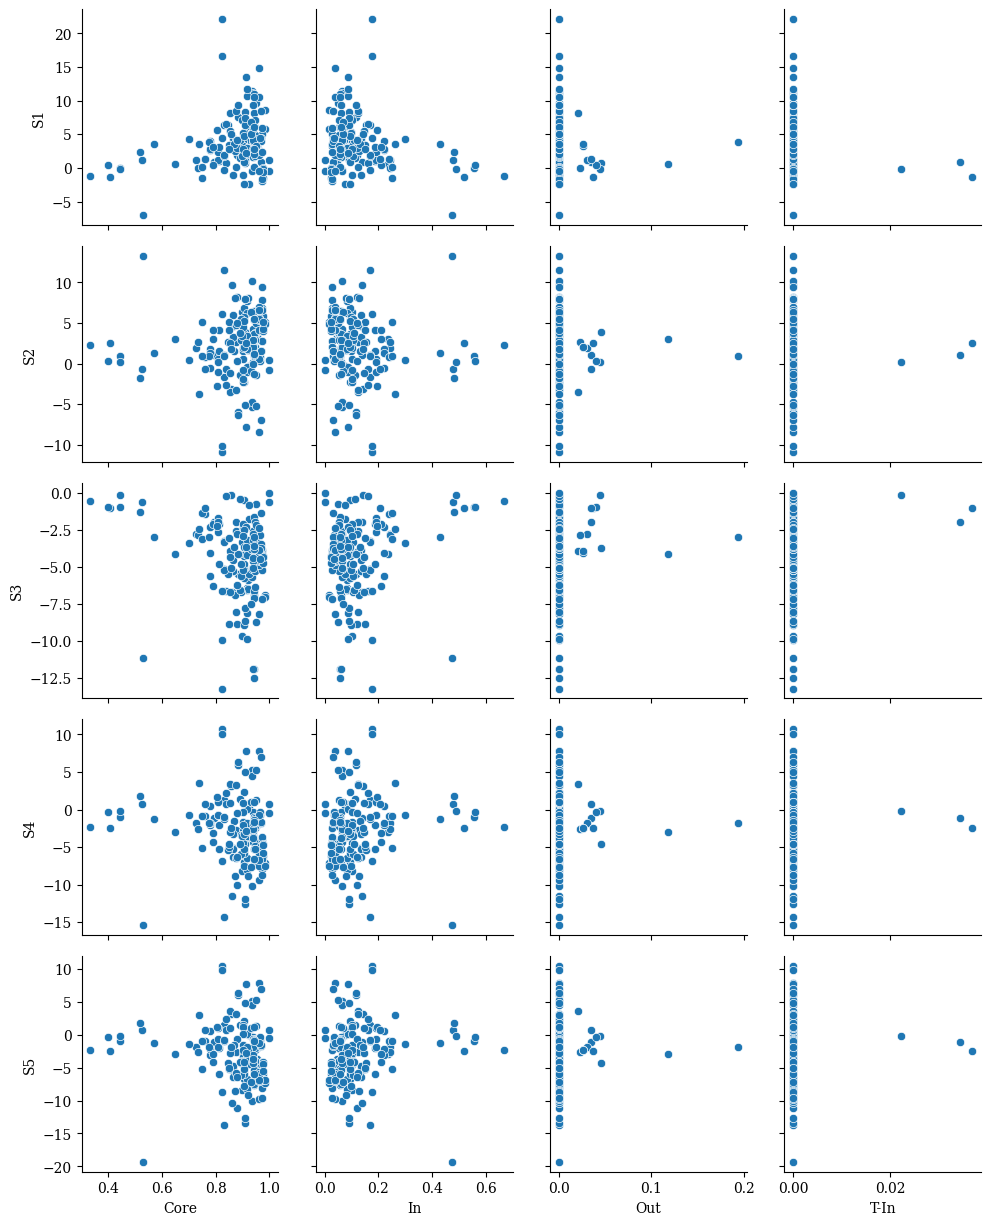

In [ ]:
#@title Periphery fraction pairplot
df_tc_z_score_path = "../dataframes/z_score_swap_living.pickle" #@param {type: "string"}
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)

image_out_path = '../images/periphery_structure_distribution_pairplot.pdf' #@param {type: "string"}
create_folder(image_out_path)
over_series = df_tc_z_score.set_index('graph_name')

plot_df = pd.concat([over_series, plot_periphery_df], axis = 1)
s_columns = ['S1', 'S2', 'S3', 'S4', 'S5']
structure_columns = ['Core', 'In', 'Out', 'T-In']

# Initialize a PairGrid
g = sns.PairGrid(plot_df, x_vars=structure_columns, y_vars=s_columns)

# Map the plots to the grid
g = g.map(sns.scatterplot)  # You can change sns.scatterplot to any other plotting function as needed

# Display the plot
plt.show()


<Axes: >

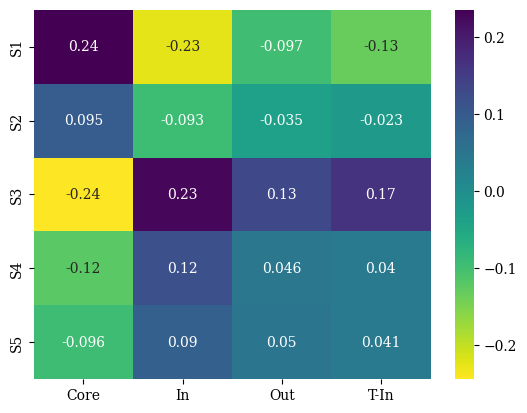

In [ ]:
s_columns = ['S1', 'S2', 'S3', 'S4', 'S5']
structure_columns = ['Core', 'In', 'Out', 'T-In']
sns.heatmap(plot_df.corr().loc[s_columns][structure_columns], annot = True, cmap = 'viridis_r')

## Generality distribution

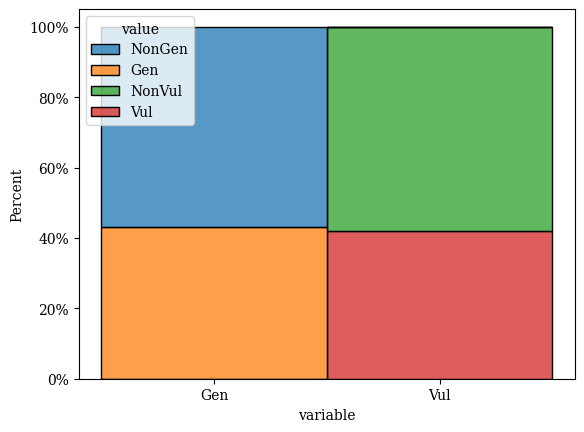

In [ ]:
#@title Generalist and vulnerable proportion
from matplotlib.ticker import PercentFormatter

gen_vul_df_path = '../dataframes/node_classification_dataframe_living.pickle' #@param {type: "string"}
image_out = '/content/gen_vul_proportion.eps' #@param {type: "string"}
plot_df = pd.read_pickle(gen_vul_df_path)

plot_df['Gen'] = plot_df['generality'].map(lambda x: 'NonGen' if x < 1 else 'Gen')
plot_df['Vul'] = plot_df['vulnerability'].map(lambda x: 'NonVul' if x < 1 else 'Vul')
plot_df = plot_df.melt(value_vars = ['Gen', 'Vul'])
fig, ax = plt.subplots()
sns.histplot(data = plot_df, x = 'variable', hue = 'value', multiple = 'stack', ax = ax, stat = 'percent')
ticks = ax.get_yticks()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=50))
fig.savefig(image_out)


<ipython-input-40-de941cbb98ad>:18: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: 100 * x / x.sum())
<ipython-input-40-de941cbb98ad>:24: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: 100 * x / x.sum())


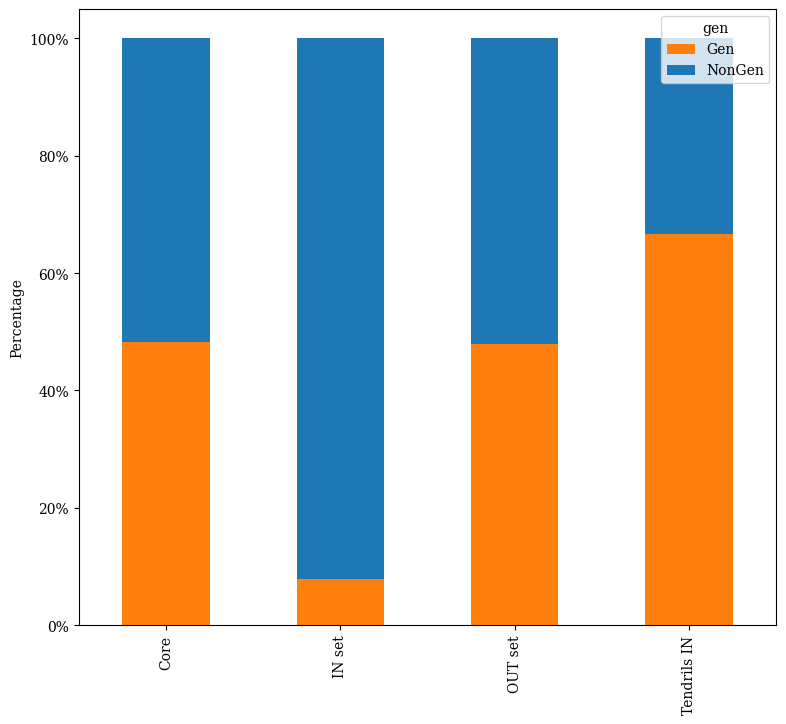

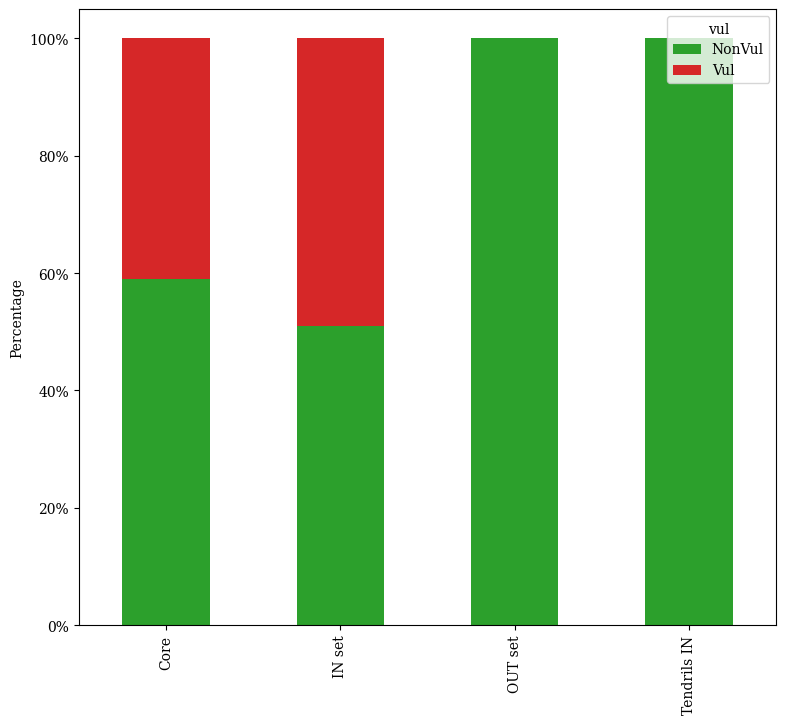

In [ ]:
#@title Generalist and vulnerable proportion in the Core/Periphery Structure

gen_vul_df_path = '../dataframes/node_classification_dataframe_living.pickle' #@param {type: "string"}
gen_output_path = '/content/gen.eps' #@param {type: "string"}
vul_output_path = '/content/vul.eps' #@param {type: "string"}

gen_vul_df = pd.read_pickle(gen_vul_df_path)
plot_df = gen_vul_df.copy()
plot_df['gen'] = plot_df['generality'].map(lambda x: 'NonGen' if x < 1 else 'Gen')
plot_df['vul'] = plot_df['vulnerability'].map(lambda x: 'NonVul' if x < 1 else 'Vul')
plot_df = plot_df.rename(columns={'periphery_structure_name': 'Periphery structure'})
plot_df = plot_df[plot_df['ECO'] == 1]

# Calculate the proportion of each category within each 'Periphery structure'
prop_df_gen = (plot_df.groupby(['Periphery structure', 'gen'])
               .size()
               .groupby(level=0)
               .apply(lambda x: 100 * x / x.sum())
               .reset_index(name='percent'))

prop_df_vul = (plot_df.groupby(['Periphery structure', 'vul'])
               .size()
               .groupby(level=0)
               .apply(lambda x: 100 * x / x.sum())
               .reset_index(name='percent'))

# Pivot the data for plotting with Matplotlib
pivot_gen = prop_df_gen.pivot(index='Periphery structure', columns='gen', values='percent')
pivot_vul = prop_df_vul.pivot(index='Periphery structure', columns='vul', values='percent')

# Plot Generality
fig, ax = plt.subplots(figsize=(9, 8))
pivot_gen.plot(kind='bar', stacked=True, ax=ax, color=['#ff7f0e', '#1f77b4'])
ax.set_xlabel('')
ax.set_ylabel('Percentage')
ax.yaxis.set_major_formatter(PercentFormatter())
fig.savefig(gen_output_path)

# Plot Vulnerability
fig, ax = plt.subplots(figsize=(9, 8))
pivot_vul.plot(kind='bar', stacked=True, ax=ax, color=['#2ca02c', '#d62728'])
ax.set_xlabel('')
ax.set_ylabel('Percentage')
ax.yaxis.set_major_formatter(PercentFormatter())
fig.savefig(vul_output_path)

plt.show()


## Robustness

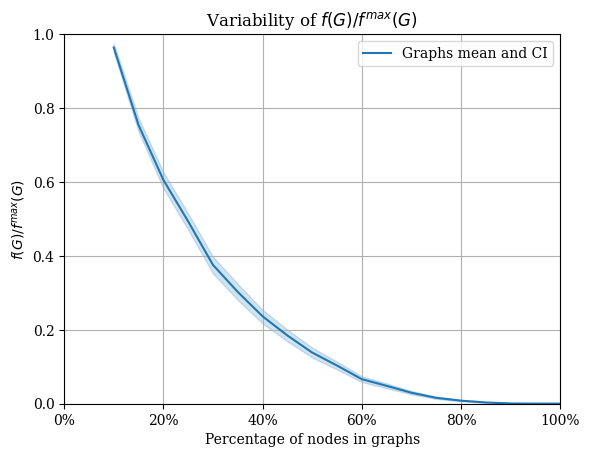

In [ ]:
#@title Variability of f(G / {v}) / f(G)
df_robustness_path_filename = '../dataframes/robustness.pickle' #@param {type: "string"}
df_node_sequence_path_filename = '../dataframes/node_sequence.pickle' #@param {type: "string"}
output_path = '../images/robustness_variability.pdf'                                     #@param {type:"string"}

robustness_df = pd.read_pickle(df_robustness_path_filename)
node_sequence_df = pd.read_pickle(df_node_sequence_path_filename)
create_folder(output_path)

# Smoothing
plot_df = node_sequence_df.copy()
## Smoothing options
smooth_scale = 5
plot_df['node_fraction'] = plot_df['node_fraction'].map(lambda x: int(x / smooth_scale + 0.5 * smooth_scale) * smooth_scale)
# Plot
fig, ax = plt.subplots()
sns.lineplot(data = plot_df, x = 'node_fraction', y = 'f_G / f_G_max', ax = ax, label = 'Graphs mean and CI')
ax.set_title(r'Variability of $f(G) / f^{max}(G)$')
ax.set_xlabel('Percentage of nodes in graphs')
ax.set_ylabel(r'$f(G) / f^{max}(G)$')
ax.grid()
ax.set_xlim((0,100))
ax.set_ylim((0,1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
fig.savefig(output_path)

Text(0.5, 1.0, 'New robustness histogram')

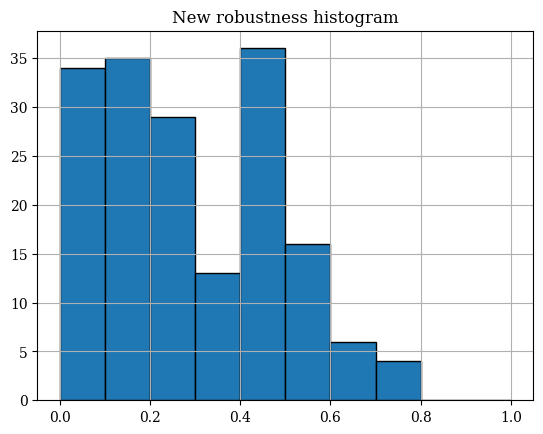

In [ ]:
#@title Another propose of robustness
df_robustness_path_filename = '../dataframes/robustness.pickle' #@param {type: "string"}
df_node_sequence_path_filename = '../dataframes/node_sequence.pickle' #@param {type: "string"}
output_path = '../images/robustness_distribution.pdf'                                     #@param {type:"string"}

robustness_df = pd.read_pickle(df_robustness_path_filename)
node_sequence_df = pd.read_pickle(df_node_sequence_path_filename)
create_folder(output_path)

fig, ax = plt.subplots()
ax.hist(robustness_df['rho_G_new'].values, bins = np.linspace(0,1,11), edgecolor='black', align = 'mid')
ax.grid()
ax.set_title("New robustness histogram")

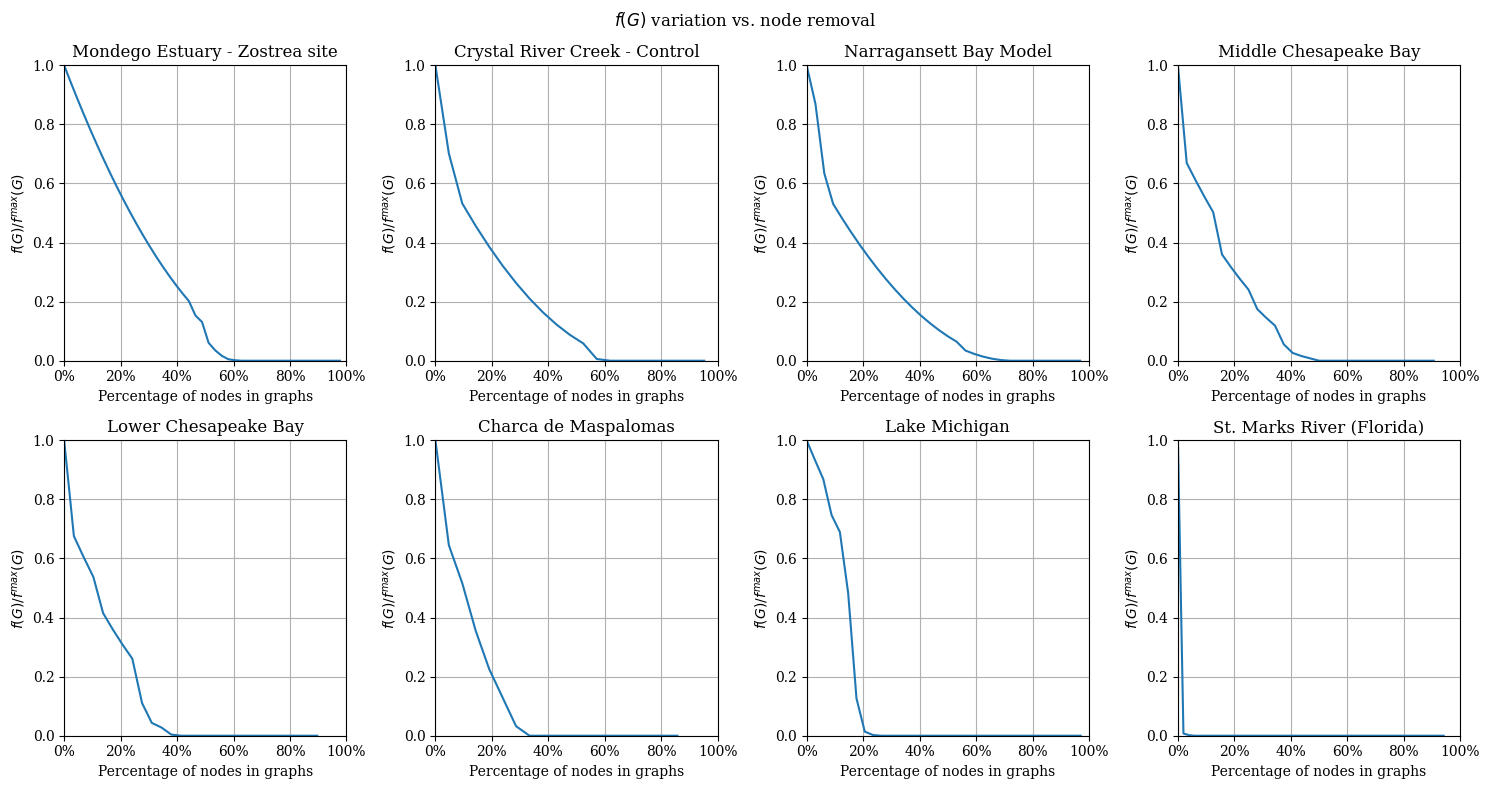

In [ ]:
#@title f(G) change
df_robustness_path_filename = '../dataframes/robustness_11.pickle' #@param {type: "string"}
df_node_sequence_path_filename = '../dataframes/node_sequence_11.pickle' #@param {type: "string"}
output_path = '../images/f_G_vs_node_perc.pdf'                                     #@param {type:"string"}

robustness_df = pd.read_pickle(df_robustness_path_filename)
node_sequence_df = pd.read_pickle(df_node_sequence_path_filename)
create_folder(output_path)

# Get graphs
all_graphs = robustness_df.sort_values(by = 'rho_G', ascending = False)['graph_name'].tolist()
graph_out = 8
rows = 2
cols = int(graph_out / rows)
skip_index = len(all_graphs) // graph_out

graphs_to_be_plotted = all_graphs[0::skip_index]
graphs_to_be_plotted[graph_out-1] = all_graphs[-1]

fig, axs = plt.subplots(rows,cols, figsize = (15,8))

for i in range(graph_out):
  data = node_sequence_df[node_sequence_df['graph_name'] == graphs_to_be_plotted[i]]
  x = data['node_fraction']
  y = data['f_G / f_G_max']
  icol = i % cols
  irow = i // cols
  axs[irow, icol].plot(x,y)
  axs[irow, icol].set_title(graphs_to_be_plotted[i])
  axs[irow, icol].set_xlabel('Percentage of nodes in graphs')
  axs[irow, icol].set_ylabel(r'$f(G) / f^{max}(G)$')
  axs[irow, icol].grid()
  axs[irow, icol].set_xlim((0,100))
  axs[irow, icol].set_ylim((0,1))
  axs[irow, icol].xaxis.set_major_formatter(mtick.PercentFormatter())

fig.suptitle(r'$f(G)$ variation vs. node removal')
fig.tight_layout()
fig.savefig(output_path)

del(data)

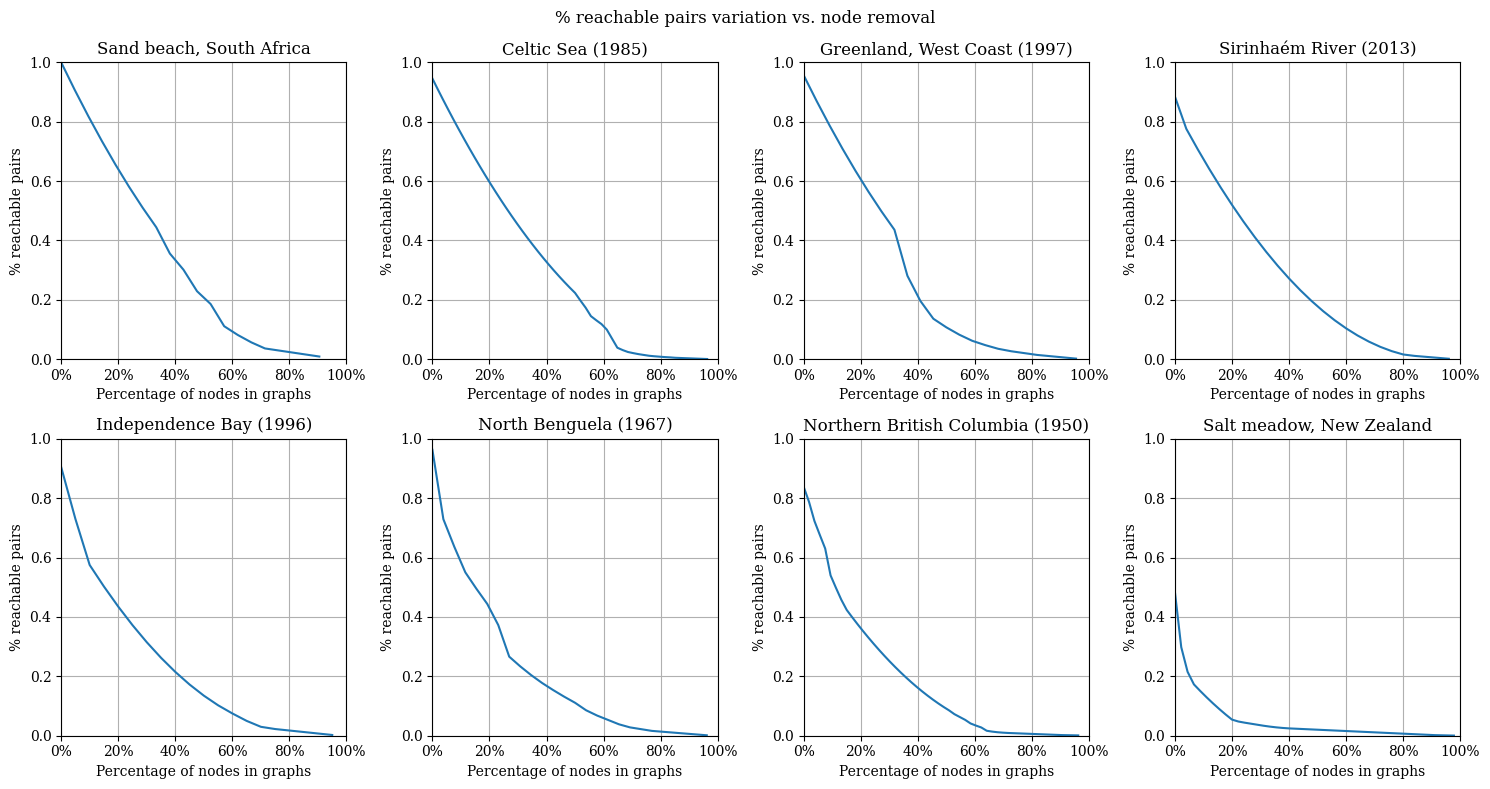

In [ ]:
#@title Percentage of reachable node pairs change
df_robustness_path_filename = '../dataframes/reachable_pairs_robustness.pickle' #@param {type: "string"}
df_node_sequence_path_filename = '../dataframes/reachable_pairs_node_sequence.pickle' #@param {type: "string"}
output_path = '/content/reachable_pairs_change.eps'   #@param {type:"string"}

robustness_df = pd.read_pickle(df_robustness_path_filename)
node_sequence_df = pd.read_pickle(df_node_sequence_path_filename)
create_folder(output_path)

# Get graphs
all_graphs = robustness_df.sort_values(by = 'rho_G', ascending = False)['graph_name'].tolist()
graph_out = 8
rows = 2
cols = int(graph_out / rows)
skip_index = len(all_graphs) // graph_out

graphs_to_be_plotted = all_graphs[0::skip_index]
graphs_to_be_plotted[graph_out-1] = all_graphs[-1]

fig, axs = plt.subplots(rows,cols, figsize = (15,8))

for i in range(graph_out):
  data = node_sequence_df[node_sequence_df['graph_name'] == graphs_to_be_plotted[i]]
  x = data['node_fraction']
  y = data['percentage_reachable_pairs']
  icol = i % cols
  irow = i // cols
  axs[irow, icol].plot(x,y)
  axs[irow, icol].set_title(graphs_to_be_plotted[i])
  axs[irow, icol].set_xlabel('Percentage of nodes in graphs')
  axs[irow, icol].set_ylabel(r'% reachable pairs')
  axs[irow, icol].grid()
  axs[irow, icol].set_xlim((0,100))
  axs[irow, icol].set_ylim((0,1))
  axs[irow, icol].xaxis.set_major_formatter(mtick.PercentFormatter())

fig.suptitle(r'% reachable pairs variation vs. node removal')
fig.tight_layout()
fig.savefig(output_path)

del(data)

In [ ]:
#@title First 3 most critical nodes table

#df_node_sequence_path_filename = '../dataframes/reachable_pairs_node_sequence.pickle' #@param {type: "string"}
# df_robustness_path_filename = '../dataframes/reachable_pairs_robustness.pickle' #@param {type: "string"}

node_sequence_df = pd.read_pickle(df_node_sequence_path_filename)
robustness_df = pd.read_pickle(df_robustness_path_filename)

graphs_sorted = robustness_df.sort_values(by = 'rho_G', ascending = False)['graph_name'].to_list()
rows = []
for i, graph_name in enumerate(graphs_sorted):
  nodes = node_sequence_df[node_sequence_df['graph_name'] == graph_name]['node_removed']
  top_3_nodes = nodes[1:4].to_list()
  rows.append((i+1, graph_name, top_3_nodes))

ranking_nodes_df = pd.DataFrame(rows, columns=['Rank', 'Food web name', '$[v^{G}_1,v^{G}_2,v^{G}_3]$'])

# Select the top 3 and bottom 3 rows
top_rows = ranking_nodes_df.head(3)
bottom_rows = ranking_nodes_df.tail(3)
# Combine them with a placeholder for the middle rows
combined_rows = pd.concat([top_rows, pd.DataFrame([['\ldots', '\ldots', '\ldots']], columns=ranking_nodes_df.columns), bottom_rows])

# Define the LaTeX tabularx environment setup
latex_string = "\\begin{tabularx}{\\textwidth}{ p{0.05\\textwidth} p{0.32\\textwidth}  p{0.57\\textwidth}}\n"
latex_string += "        \\toprule\n"
latex_string += "          \\textbf{Rank} & \\textbf{Graph name} & \\textbf{$[v^{G}_1,v^{G}_2,v^{G}_3]$} \\\\\n"
latex_string += "        \\midrule\n"

# Define the color to use for the rowcolor command
row_color = "\\rowcolor{LightBlue}"

# Loop through the dataframe and create the table
i = 0
for _, row in combined_rows.iterrows():
    if i % 2 == 0:
        i += 1
        latex_string += f"        {row_color} {row['Rank']} & {row['Food web name']} & {row['$[v^{G}_1,v^{G}_2,v^{G}_3]$']} \\\\\n"
    else:
        latex_string += f"        {row['Rank']} & {row['Food web name']} & {row['$[v^{G}_1,v^{G}_2,v^{G}_3]$']} \\\\\n"
        i = 0
latex_string += "    \\bottomrule\n"
latex_string += "\\end{tabularx}"

# Print the LaTeX table string
print(latex_string)


\begin{tabularx}{\textwidth}{ p{0.05\textwidth} p{0.32\textwidth}  p{0.57\textwidth}}
        \toprule
          \textbf{Rank} & \textbf{Graph name} & \textbf{$[v^{G}_1,v^{G}_2,v^{G}_3]$} \\
        \midrule
        \rowcolor{LightBlue} 1 & Sand beach, South Africa & ['Gastrosaccus, Callianassa, Donax', 'bacteria', 'Cumacea'] \\
        2 & Sítios Novos reservoir (2011) & ['A.bimaculatus', 'A.brasiliensis adulto', 'A.brasiliensis juvenil'] \\
        \rowcolor{LightBlue} 3 & Contemporary Alosine (2000) & ['Alosines', 'Anchovies', 'Atlantic herring'] \\
        \ldots & \ldots & \ldots \\
        \rowcolor{LightBlue} 171 & Chesapeake Bay Mesohaline & ['bacteria in sediment poc', 'zooplankton', 'blue crab'] \\
        172 & St. Marks River (Florida) & ['Benthic bact', 'Bacterio plankton', 'Micro protozoa'] \\
        \rowcolor{LightBlue} 173 & Salt meadow, New Zealand & ['amphipods', 'collembola', 'mites'] \\
    \bottomrule
\end{tabularx}


## Ego networks

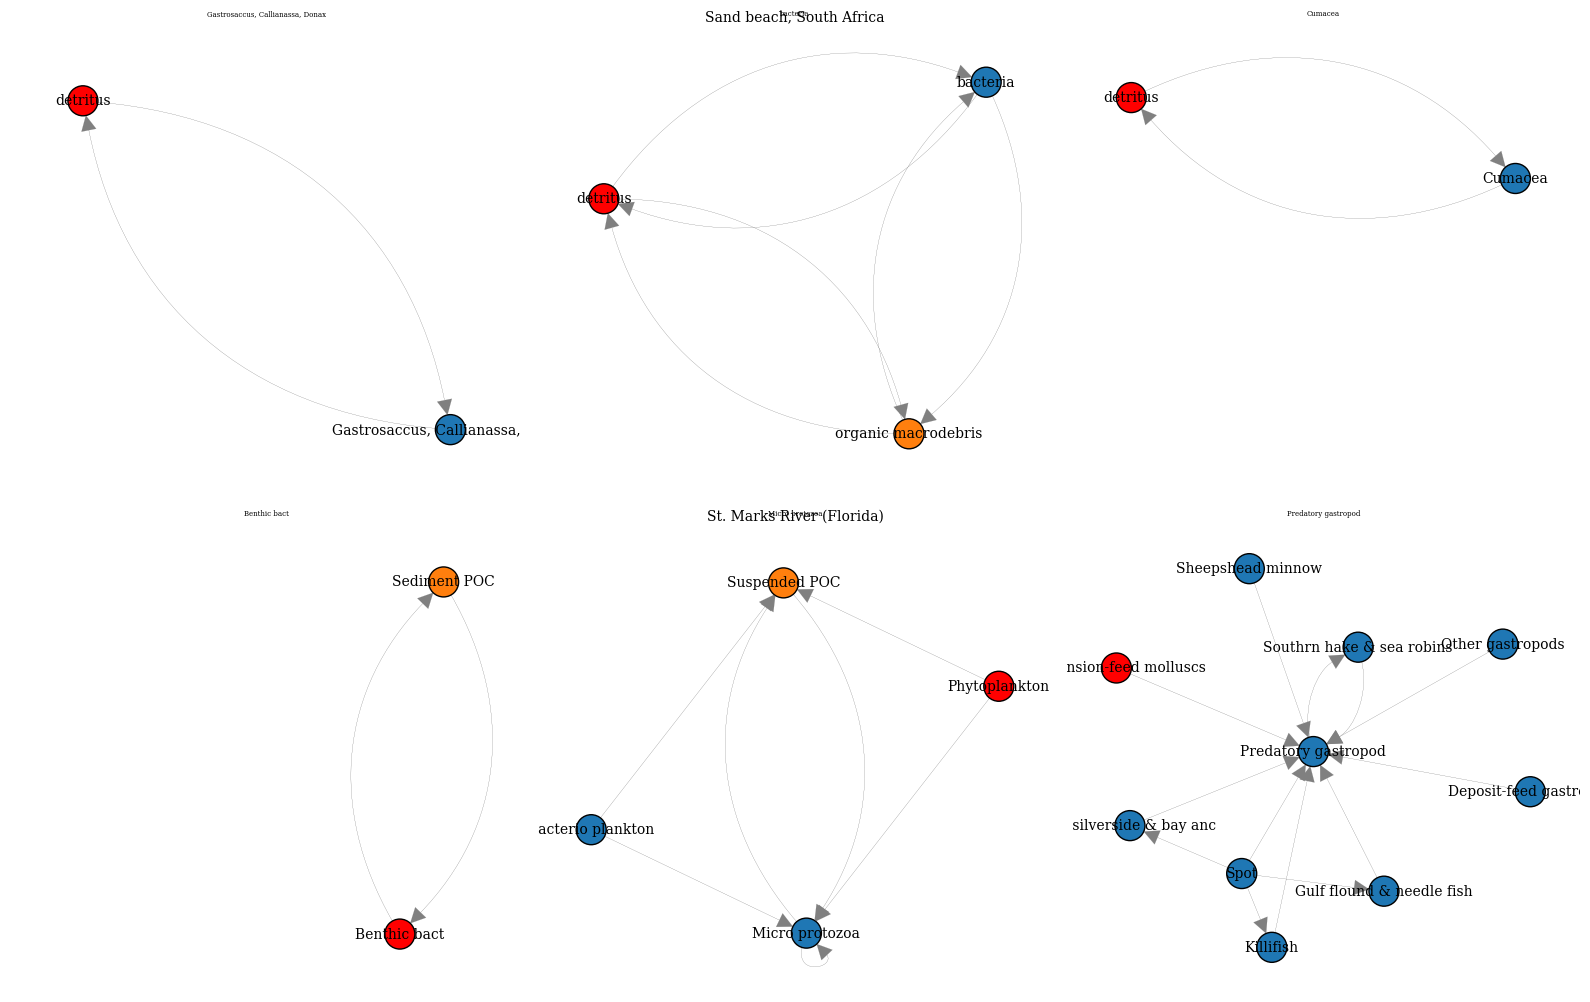

In [ ]:
#@title Ego networks of most critical nodes

df_robustness_path_filename = '../dataframes/robustness.pickle' #@param {type: "string"}
df_top_critical_nodes_path = '../dataframes/critical_nodes.pickle' #@param {type: "string"}
output_path = '../images/egonets_critical_nodes.pdf'                                     #@param {type:"string"}

critical_nodes_df = pd.read_pickle(df_top_critical_nodes_path).set_index('graph_name')
df_robustness = pd.read_pickle(df_robustness_path_filename)

graph_name_sorted = df_robustness.sort_values(by='rho_G', ascending=False).graph_name.tolist()
most_robust_graph = graph_name_sorted[0]
least_robust_graph = graph_name_sorted[-1]

# create 2 x n_critical_nodes subplots
n_critical_nodes = len(critical_nodes_df.iloc[0,0])

fig = plt.figure(tight_layout=True, figsize = (16, 10))
fig.suptitle('Ego networks of most critical nodes', size = 15)
subfigs = fig.subfigures(2, 1)

for ifig, graph_name in enumerate([most_robust_graph, least_robust_graph]):

    subfig = subfigs[ifig]
    subfig.suptitle(f'{graph_name}', size = 10)

    # set the axis
    axs = subfig.subplots(1, n_critical_nodes)

    # get the graph
    igr = index_from_dataset(G_dataset, graph_name)
    G = G_dataset[igr]
    critical_nodes_list = critical_nodes_df.loc[graph_name,'node_sequence']
    for i, node in enumerate(critical_nodes_list):
      G_sub, vs = ego_net(G, node, mode='in')
      vs['vertex_color'][0] = 'red'
      ig.plot(G_sub, target = axs[i], **vs)
      axs[i].set_title(f'{node}', size = 5)

fig.tight_layout()
fig.savefig(output_path)

<ipython-input-47-ca021af3e56a>:36: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.tight_layout()


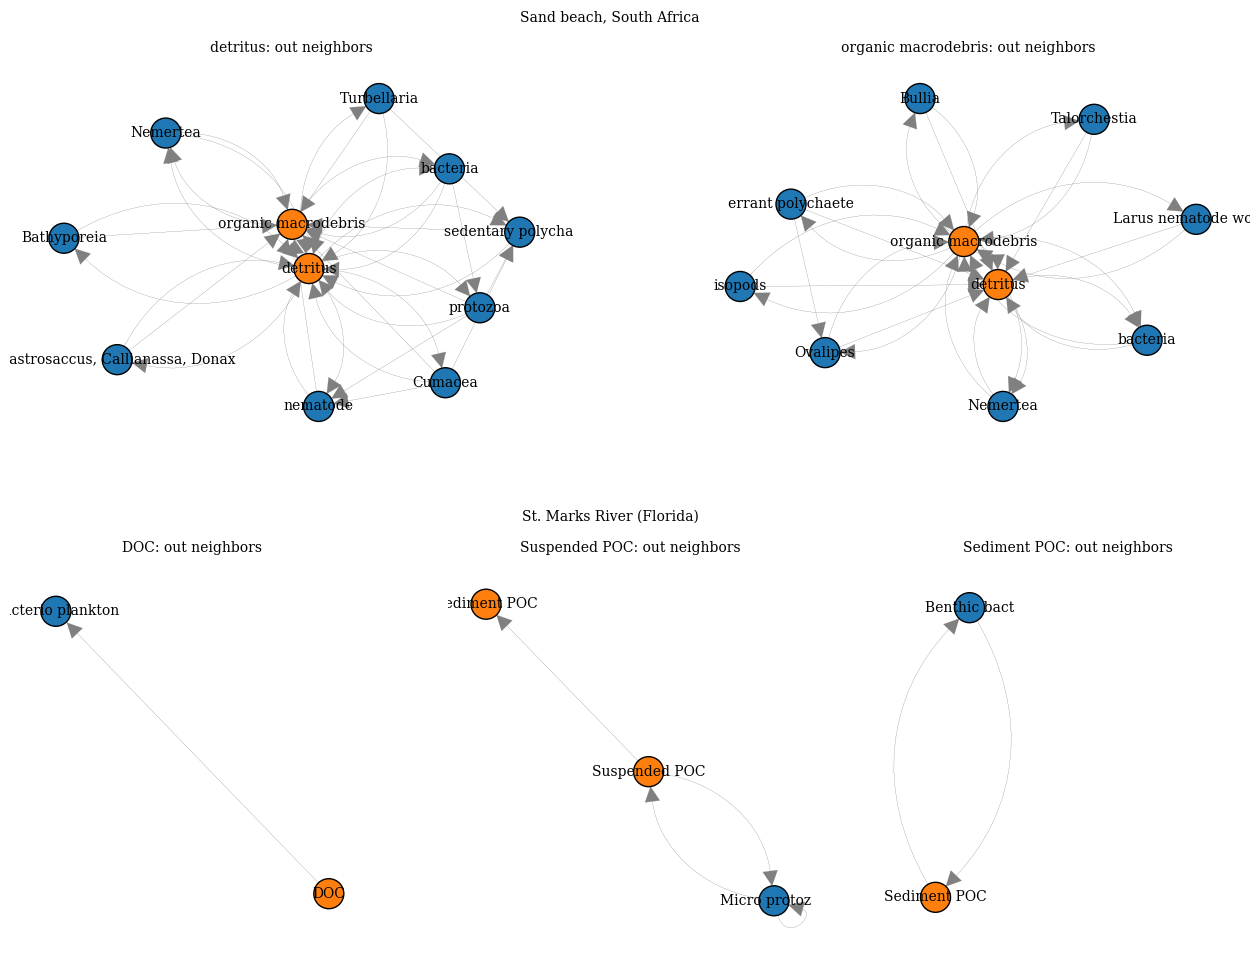

In [ ]:
#@title Ego networks of other compartments (debris, detriti, etc.)

df_robustness_path_filename = '../dataframes/robustness.pickle' #@param {type: "string"}
df_top_critical_nodes_path = '../dataframes/critical_nodes.pickle' #@param {type: "string"}
output_path = '/content/other_compartments_out_ego.eps'                                     #@param {type:"string"}

critical_nodes_df = pd.read_pickle(df_top_critical_nodes_path).set_index('graph_name')
df_robustness = pd.read_pickle(df_robustness_path_filename)

graph_name_sorted = df_robustness.sort_values(by='rho_G', ascending=False).graph_name.tolist()
most_robust_graph = graph_name_sorted[0]
least_robust_graph = graph_name_sorted[-1]

fig = plt.figure(tight_layout=True, figsize = (16, 10))
fig.suptitle('Ego networks', size = 15)
subfigs = fig.subfigures(2, 1)

for ifig, graph_name in enumerate([most_robust_graph, least_robust_graph]):

    subfig = subfigs[ifig]
    subfig.suptitle(f'{graph_name}', size = 10)

    # get the graph
    igr = index_from_dataset(G_dataset, graph_name)
    G = G_dataset[igr]
    # get the nodes
    detriti_nodes = [v['name'] for v in G.vs if v['ECO'] == 2]
    # set the axis
    axs = subfig.subplots(1, len(detriti_nodes))

    for i, node in enumerate(detriti_nodes):
      G_sub, vs = ego_net(G, node, mode = 'out')
      ig.plot(G_sub, target = axs[i], **vs)
      axs[i].set_title(f'{node}: out neighbors', size = 10)

fig.tight_layout()
fig.savefig(output_path)

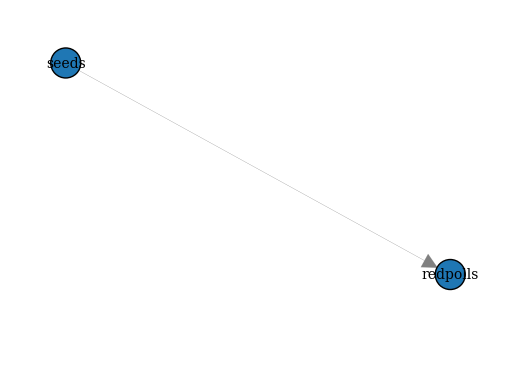

In [ ]:
#@title Other ego networks
graph_name = 'Salt meadow, New Zealand'
node_name = 'redpolls'
graph_index = index_from_dataset(G_dataset, graph_name)
G = G_dataset[graph_index]

node = [v for v in G.vs() if v['name'] == node_name][0]
G_sub, vs = ego_net(G, node, mode = 'all')
fig, ax = plt.subplots()
ig.plot(G_sub, target = ax, **vs)

## Z-score

In [ ]:
df_tc_z_score_path = '../dataframes/z_score_swap_living.pickle'             #@param {type:"string"}

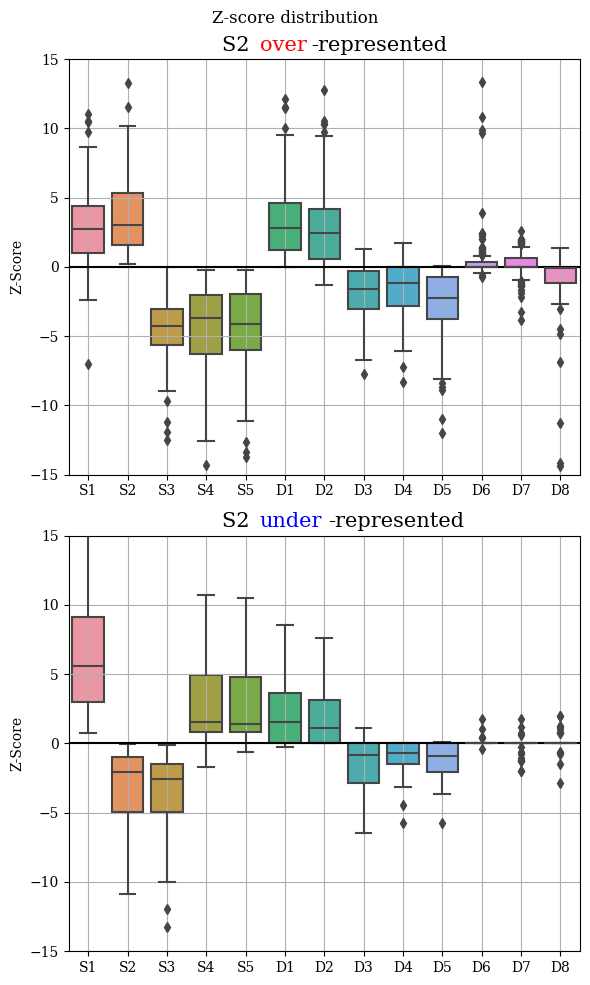

In [ ]:
#@title Z-score #1

output_path = '../images/z_score_1.pdf'                                     #@param {type:"string"}
create_folder(output_path)

df_tc_z_score = pd.read_pickle(df_tc_z_score_path)

fig, axs = plt.subplots(2,1, figsize=(6,10))
fig.canvas.draw()

sns.boxplot(data = df_tc_z_score[df_tc_z_score['S2'] > 0], ax = axs[0])
axs[0].grid()
axs[0].set_ylim((-15,15))
axs[0].set_ylabel('Z-Score')
axs[0].axhline(0, c='black')

transform_1 = axs[0].transAxes
title_words = ['S2 ', 'over', '-represented']
colors = ['black', 'red', 'black']
x_pos = 0.3
for string, col in zip(title_words, colors):
  t = axs[0].text(x_pos, 1.02, string, transform = transform_1, color = col, size = 15)
  bbox = t.get_window_extent().transformed(transform_1.inverted())
  x_pos = bbox.x1

sns.boxplot(data = df_tc_z_score[df_tc_z_score['S2'] < 0], ax = axs[1])
axs[1].grid()
axs[1].set_ylim((-15,15))
axs[1].set_ylabel('Z-Score')
axs[1].axhline(0, c='black')

transform_2 = axs[1].transAxes
title_words = ['S2 ', 'under', '-represented']
colors = ['black', 'blue', 'black']
x_pos = 0.3
for string, col in zip(title_words, colors):
  t = axs[1].text(x_pos, 1.02, string, transform = transform_2, color = col, size = 15)
  bbox = t.get_window_extent().transformed(transform_2.inverted())
  x_pos = bbox.x1

fig.suptitle('Z-score distribution')
fig.tight_layout()
fig.savefig(output_path)

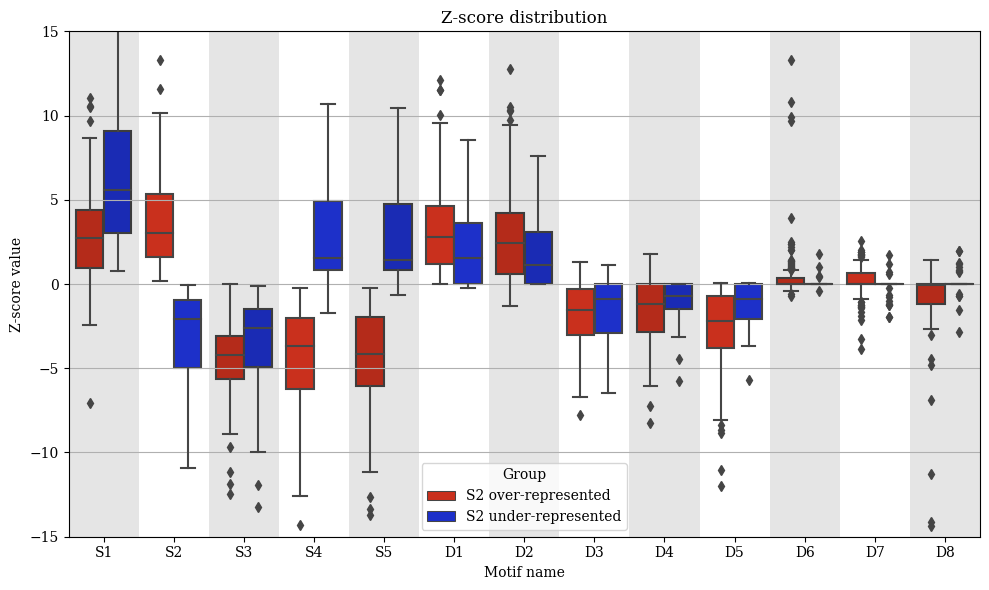

In [ ]:
#@title Z-score #2
from matplotlib.patches import Rectangle

output_path = '../images/z_score_2.pdf'                                     #@param {type:"string"}
create_folder(output_path)
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)

plot_box_df = df_tc_z_score.copy()
plot_box_df['Group'] = plot_box_df['S2'].map(lambda x: 'S2 over-represented' if x>0 else 'S2 under-represented')
plot_box_df = pd.melt(plot_box_df, id_vars = ['graph_name', 'Group'])

fig, ax = plt.subplots(figsize = (10, 6))
y_lim = (-15,15)
y_extend = y_lim[1] - y_lim[0]
dwn_extend = y_extend / 6.
for x0 in np.arange(-0.5, 13, 2):
  ax.add_patch(Rectangle((x0, y_lim[0] - dwn_extend), 1,  y_lim[1] - y_lim[0] + 2 * dwn_extend, facecolor='black', alpha = 0.1))

palette = [(0.9, 0.1, 0.0), (0.0, 0.1, 0.9)]
sns.boxplot(data = plot_box_df, x = 'variable', y = 'value', hue = 'Group', ax = ax, palette = palette)

ax.grid(axis='y')
ax.set_ylabel('Z-score value')
ax.set_xlabel('Motif name')
ax.set_title('Z-score distribution')
ax.set_ylim(y_lim)
fig.show()
fig.tight_layout()
fig.savefig(output_path)


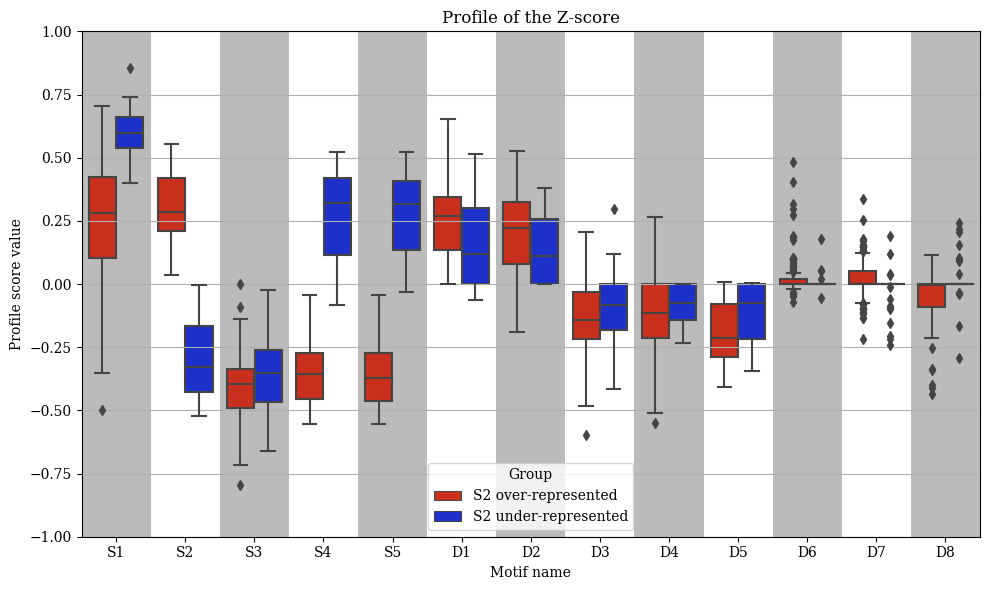

In [ ]:
#@title Profile of Z-score #2
from matplotlib.patches import Rectangle

output_path = '/content/profile_z_score_2.eps'                                     #@param {type:"string"}
create_folder(output_path)
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)

profile_df = df_tc_z_score.copy().set_index('graph_name')
values = profile_df.values
values_sqrt_sum = np.sqrt(1 / np.sum(np.power(values, 2), axis = 1))
P = values * values_sqrt_sum[:, np.newaxis]
P_df = pd.DataFrame(P, index = profile_df.index, columns = profile_df.columns).reset_index()
plot_box_df = P_df.copy()
plot_box_df['Group'] = plot_box_df['S2'].map(lambda x: 'S2 over-represented' if x>0 else 'S2 under-represented')
plot_box_df = pd.melt(plot_box_df, id_vars = ['graph_name', 'Group'])

fig, ax = plt.subplots(figsize = (10, 6))
y_lim = (-1,1)
y_extend = y_lim[1] - y_lim[0]
dwn_extend = y_extend / 6.
for x0 in np.arange(-0.5, 13, 2):
  ax.add_patch(Rectangle((x0, y_lim[0] - dwn_extend), 1,  y_lim[1] - y_lim[0] + 2 * dwn_extend, facecolor='#BBBBBB', zorder = 0))

palette = [(0.9, 0.1, 0.0), (0.0, 0.1, 0.9)]
sns.boxplot(data = plot_box_df, x = 'variable', y = 'value', hue = 'Group', ax = ax, palette = palette)

ax.grid(axis='y')
ax.set_ylabel('Profile score value')
ax.set_xlabel('Motif name')
ax.set_title('Profile of the Z-score')
ax.set_ylim(y_lim)
fig.show()
fig.tight_layout()
fig.savefig(output_path)


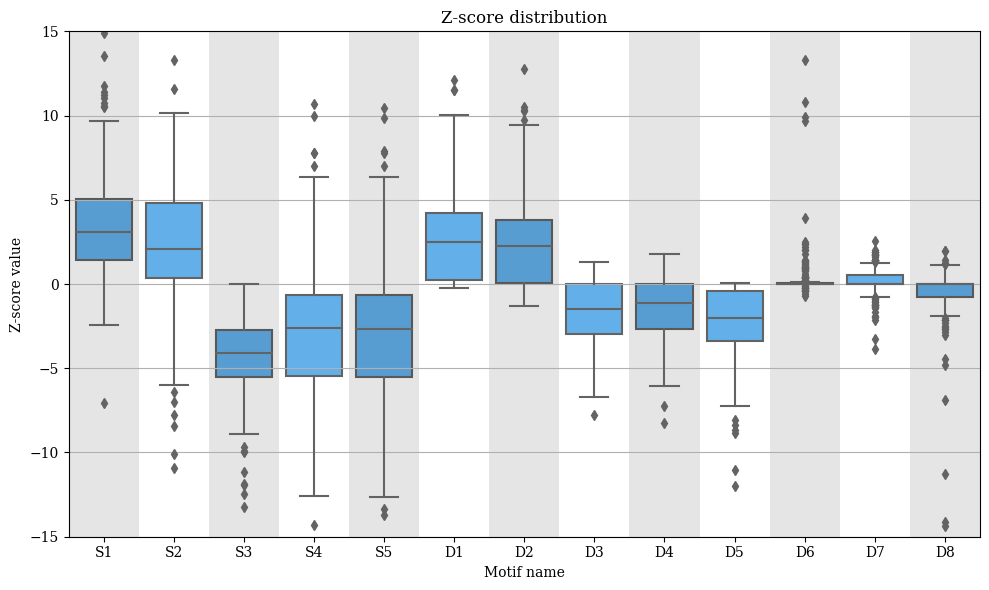

In [ ]:
#@title Z-score #3
from matplotlib.patches import Rectangle

output_path = '../images/z_score_3.pdf'                                     #@param {type:"string"}
create_folder(output_path)
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)

plot_box_df = df_tc_z_score.copy()
plot_box_df = pd.melt(plot_box_df, id_vars = ['graph_name'])

fig, ax = plt.subplots(figsize = (10, 6))
y_lim = (-15,15)
y_extend = y_lim[1] - y_lim[0]
dwn_extend = y_extend / 6.
for x0 in np.arange(-0.5, 13, 2):
  ax.add_patch(Rectangle((x0, y_lim[0] - dwn_extend), 1,  y_lim[1] - y_lim[0] + 2 * dwn_extend, facecolor='black', alpha = 0.1))


sns.boxplot(data = plot_box_df, x = 'variable', y = 'value', ax = ax, palette = [(0.3, 0.7, 1,1)])

ax.grid(axis='y')
ax.set_ylabel('Z-score value')
ax.set_xlabel('Motif name')
ax.set_title('Z-score distribution')
ax.set_ylim(y_lim)
fig.show()
fig.tight_layout()
fig.savefig(output_path)


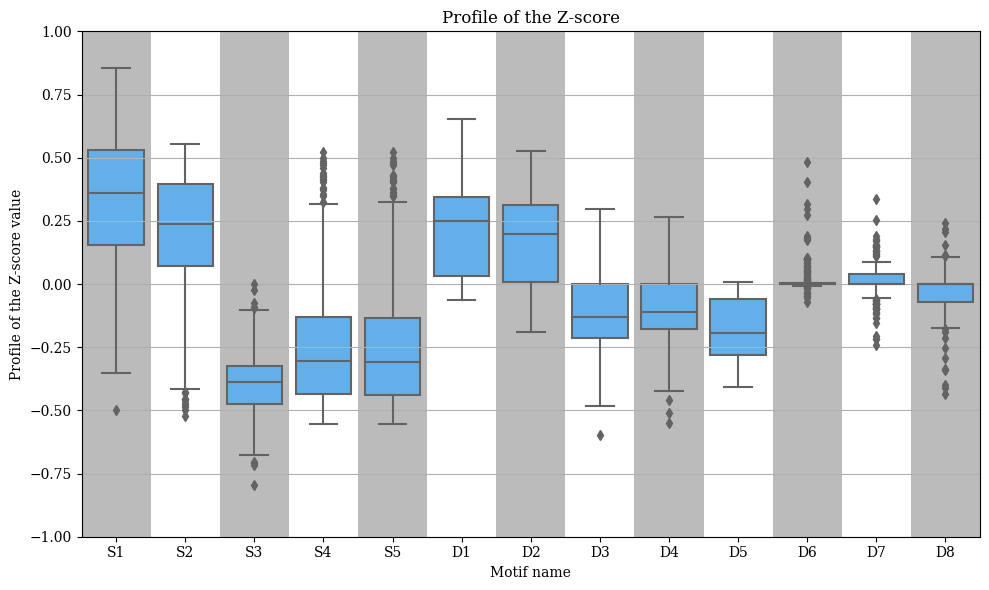

In [ ]:
#@title Profile of Z-score #3
from matplotlib.patches import Rectangle

output_path = '/content/profile_z_score_3.eps'                                     #@param {type:"string"}
create_folder(output_path)
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)

profile_df = df_tc_z_score.copy().set_index('graph_name')
values = profile_df.values
values_sqrt_sum = np.sqrt(1 / np.sum(np.power(values, 2), axis = 1))
P = values * values_sqrt_sum[:, np.newaxis]
P_df = pd.DataFrame(P, index = profile_df.index, columns = profile_df.columns).reset_index()
plot_box_df = P_df.copy()
plot_box_df = pd.melt(plot_box_df, id_vars = ['graph_name'])

fig, ax = plt.subplots(figsize = (10, 6))
y_lim = (-1,1)
y_extend = y_lim[1] - y_lim[0]
dwn_extend = y_extend / 6.
for x0 in np.arange(-0.5, 13, 2):
  ax.add_patch(Rectangle((x0, y_lim[0] - dwn_extend), 1,  y_lim[1] - y_lim[0] + 2 * dwn_extend, facecolor='#BBBBBB', zorder = 0))


sns.boxplot(data = plot_box_df, x = 'variable', y = 'value', ax = ax, palette = [(0.3, 0.7, 1,1)])

ax.grid(axis='y')
ax.set_ylabel('Profile of the Z-score value')
ax.set_xlabel('Motif name')
ax.set_title('Profile of the Z-score')
ax.set_ylim(y_lim)
fig.show()
fig.tight_layout()
fig.savefig(output_path)


In [ ]:
#@title Table: motif representation #1
from matplotlib.patches import Rectangle

# output_path = '/content/profile_z_score_3.eps'                                     #@param {type:"string"}
create_folder(output_path)
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)

profile_df = df_tc_z_score.copy().set_index('graph_name')
profile_df.applymap(lambda x: '+' if x>0 else ('=' if x == 0 else '-'))
profile_df.applymap(lambda x: '+' if x>0 else ('=' if x == 0 else '-')).to_excel('../dataframes/motif_representation_table_1.xlsx')

In [ ]:
#@title Table: motif representation #2
from matplotlib.patches import Rectangle

# output_path = '/content/profile_z_score_3.eps'                                     #@param {type:"string"}
create_folder(output_path)
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)

profile_df = df_tc_z_score.copy().set_index('graph_name')
profile_df.applymap(lambda x: '🔺' if x>0 else ('-' if x == 0 else '⬇')).to_excel('../dataframes/motif_representation_table_2.xlsx')

In [ ]:
#@title Profile of Z-score proportion
from collections import Counter

output_path = '/content/profile_z_score_proportion.eps'                                     #@param {type:"string"}
create_folder(output_path)
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)

profile_df = df_tc_z_score.copy().set_index('graph_name')
values = profile_df.values
values_sqrt_sum = np.sqrt(1 / np.sum(np.power(values, 2), axis = 1))
P = values * values_sqrt_sum[:, np.newaxis]
P_df = pd.DataFrame(P, index = profile_df.index, columns = profile_df.columns).reset_index()
plot_box_df = P_df.copy()
plot_box_df['Group'] = plot_box_df['S2'].map(lambda x: 'S2 over-represented' if x>0 else 'S2 under-represented')

Counter(plot_box_df['Group'].to_list())
# fig, ax = plt.subplots(figsize = (10, 6))
# fig.show()
# fig.tight_layout()
# fig.savefig(output_path)


Counter({'S2 over-represented': 134, 'S2 under-represented': 38})

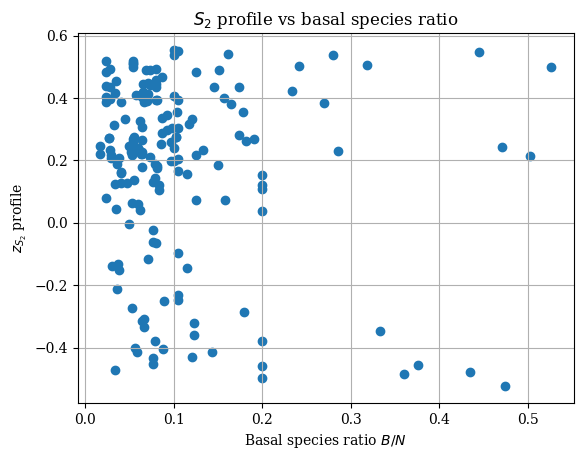

In [ ]:
#@title Basal nodes ratio vs. S2 representation profile score
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)
s2_profile_array = []
basal_ratio = []

for graph_name in df_tc_z_score['graph_name']:
  index = index_from_dataset(G_dataset, graph_name)
  G = G_dataset[index].copy()
  living_vertices = [v for v in G.vs() if v['ECO'] == 1]
  G_living = G.subgraph(living_vertices)
  in_degree = np.array(G_living.indegree())
  basal_species = np.sum(in_degree == 0)
  living_species = G_living.vcount()

  z_score_s2 = float(df_tc_z_score[df_tc_z_score['graph_name'] == graph_name].loc[:,'S2'])
  z_score_row = df_tc_z_score[df_tc_z_score['graph_name'] == graph_name].drop('graph_name', axis = 1).loc[:,:]
  z_score_vector = z_score_row.to_numpy()
  z_score_magnitude = float(np.sqrt(np.dot(z_score_vector, z_score_vector.T)))
  s2_profile = z_score_s2 / z_score_magnitude

  basal_ratio.append(basal_species / living_species)
  s2_profile_array.append(s2_profile)

fig, ax = plt.subplots()
ax.scatter(basal_ratio, s2_profile_array)
ax.set_xlabel(r'Basal species ratio $B / N$')
ax.set_ylabel(r'$z_{S_2}$ profile')
ax.set_title(r'$S_2$ profile vs basal species ratio')
ax.grid()

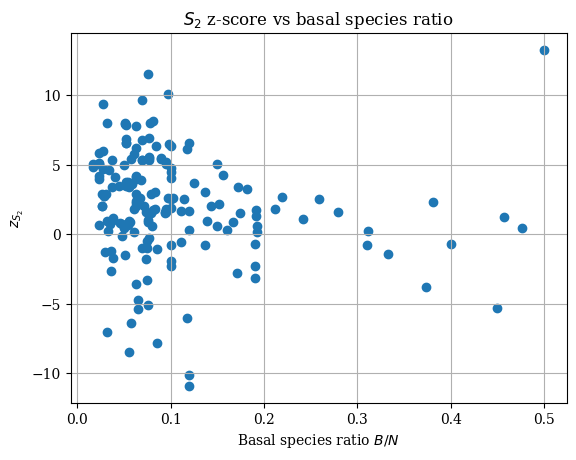

In [ ]:
#@title Basal nodes vs. S2 representation
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)
s2_profile_array = []
basal_ratio = []

for graph_name in df_tc_z_score['graph_name']:
  index = index_from_dataset(G_dataset, graph_name)
  G = G_dataset[index].copy()
  living_vertices = [v for v in G.vs() if v['ECO'] == 1]
  G_living = G.subgraph(living_vertices)
  in_degree = np.array(G_living.indegree())
  basal_species = np.sum(in_degree == 0)
  species = G.vcount()

  z_score_s2 = float(df_tc_z_score[df_tc_z_score['graph_name'] == graph_name].loc[:,'S2'])
  z_score_row = df_tc_z_score[df_tc_z_score['graph_name'] == graph_name].drop('graph_name', axis = 1).loc[:,:]
  z_score_vector = z_score_row.to_numpy()
  z_score_magnitude = float(np.sqrt(np.dot(z_score_vector, z_score_vector.T)))
  s2_profile = z_score_s2 / z_score_magnitude

  basal_ratio.append(basal_species / species)
  s2_profile_array.append(z_score_s2)

fig, ax = plt.subplots()
ax.scatter(basal_ratio, s2_profile_array)
ax.set_xlabel(r'Basal species ratio $B / N$')
ax.set_ylabel(r'$z_{S_2}$')
ax.set_title(r'$S_2$ z-score vs basal species ratio')
ax.grid()

# Other result analysis

In [ ]:
from collections import Counter
df_s2_top_taxa_path = '../dataframes/s2_top_taxa.pickle' #@param{type: 'string'}
mode = 'load' #@param ['save', 'load']
df_living_creature_role_path = '../dataframes/taxa_role.pickle' #@param{type: 'string'}
df_z_score_path = '../dataframes/z_score_swap_living.pickle' #@param {type: 'string'}

if mode == 'save':
  role_df = pd.read_pickle(df_living_creature_role_path)
  z_score_df = pd.read_pickle(df_z_score_path)

  rows = []
  for graph_name in z_score_df['graph_name']:
    top_species = role_df[(role_df['graph_name'] == graph_name) & (role_df['motif_name'] == 'S2') & (role_df['role'] == 'top')]['node_name']
    s2_score = float(z_score_df[z_score_df['graph_name'] == graph_name].loc[:,'S2'])
    ts_dict = dict(Counter(top_species))
    rows.append((graph_name, s2_score, ts_dict))

  s2_top_taxa = pd.DataFrame(rows, columns = ['Graph name', 'S2 z-score', 'Top species in the S2 motif node counter'])
  s2_top_taxa.to_pickle(df_s2_top_taxa_path)
  print(f'Data saved in {df_s2_top_taxa_path}')

elif mode == 'load':
  s2_top_taxa = pd.read_pickle(df_s2_top_taxa_path)
  print(f'Data in {df_s2_top_taxa_path} loaded correctly')

else:
  raise Exception(f'Mode {mode} not implemented yet')

Data in ../dataframes/s2_top_taxa.pickle loaded correctly


In [ ]:
nodes_classification_df[nodes_classification_df['periphery_structure_name'] == 'Tendrils IN']


,graph_name,node_id,node_name,ECO,periphery_structure_name,generality,vulnerability
28,Lower Chesapeake Bay,6,Rotifers,1.0,Tendrils IN,0.252174,0.0
3750,"Tasek Bera swamp, Malaysia",24,swallows,1.0,Tendrils IN,1.113402,0.0
5584,"Salt meadow, New Zealand",26,redpolls,1.0,Tendrils IN,0.505618,0.0


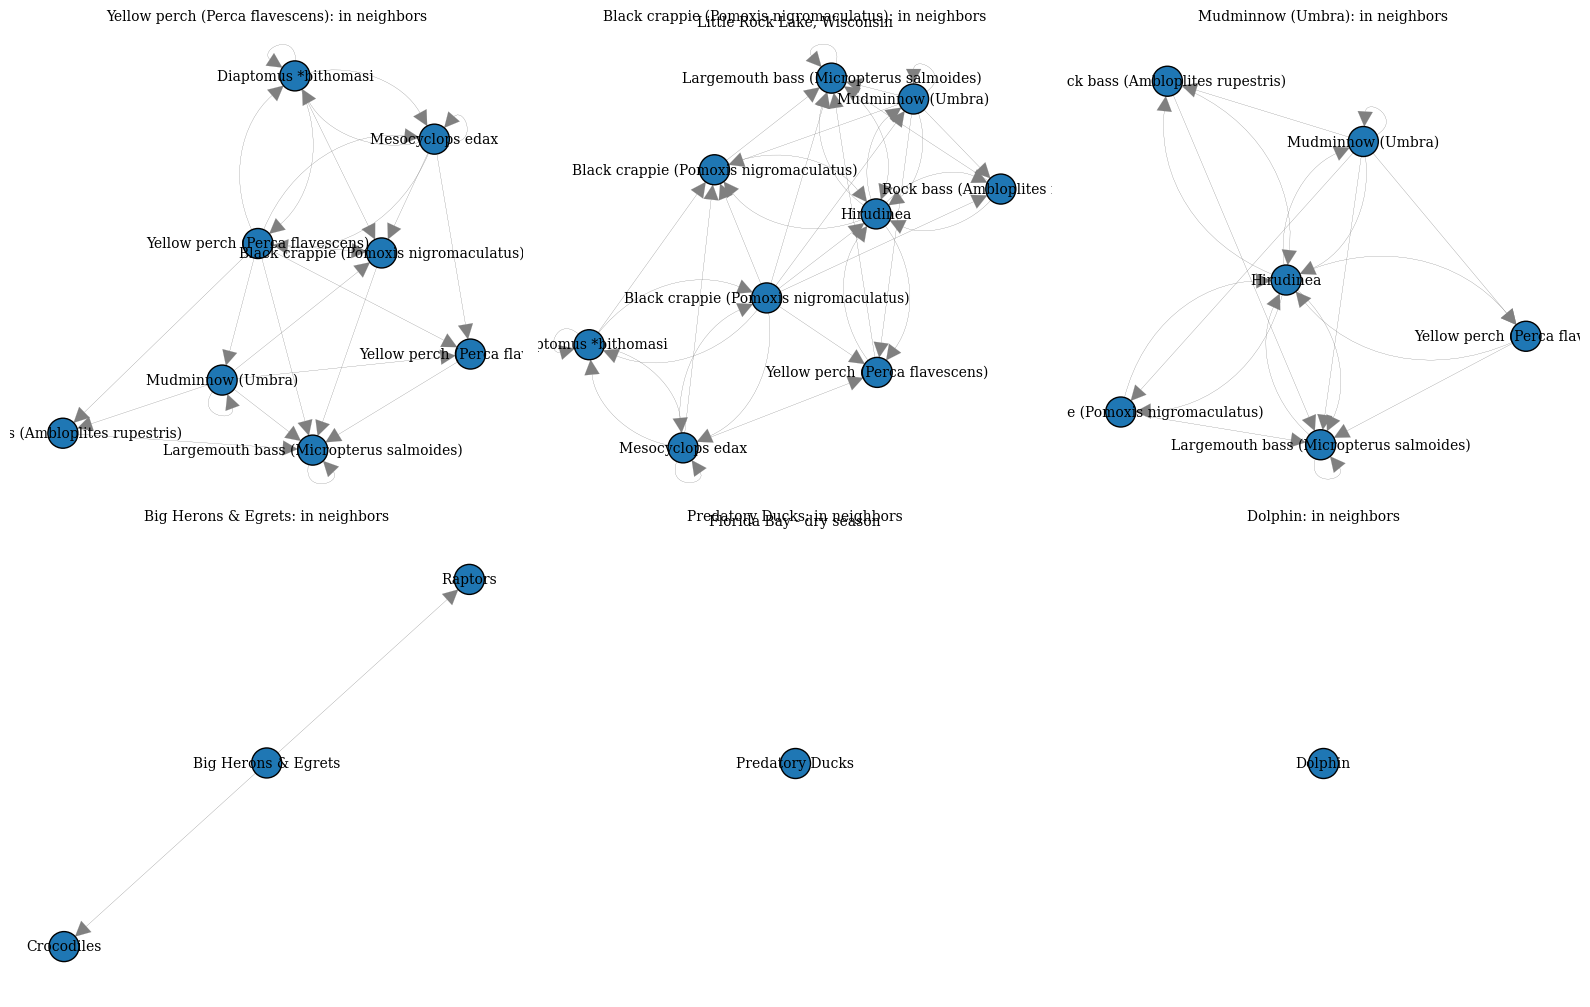

In [ ]:
#@title Ego networks of top species in S2

df_s2_top_taxa_path = '../dataframes/s2_top_taxa.pickle' #@param{type: 'string'}
output_path = '../images/egonets_s2_top_taxa.pdf'                                     #@param {type:"string"}

s2_top_df = pd.read_pickle(df_s2_top_taxa_path)

graph_name_sorted = s2_top_df.sort_values(by='S2 z-score', ascending=False)['Graph name'].tolist()
most_s2_rich_graph = graph_name_sorted[0]
least_s2_rich_graph = graph_name_sorted[-1]

fig = plt.figure(tight_layout=True, figsize = (16, 10))
fig.suptitle('Ego networks', size = 15)
subfigs = fig.subfigures(2, 1)

for ifig, graph_name in enumerate([most_s2_rich_graph, least_s2_rich_graph]):

    subfig = subfigs[ifig]
    subfig.suptitle(f'{graph_name}', size = 10)

    # get the graph
    igr = index_from_dataset(G_dataset, graph_name)
    G = G_dataset[igr]
    G_living = G.subgraph([v for v in G.vs() if v['ECO'] == 1])
    # get the nodes
    species = s2_top_df[s2_top_df['Graph name'] == graph_name].iloc[0,2]
    top_3_species = [key for key, value in sorted(species.items(), key = lambda x: -x[1])][:3]    # set the axis
    axs = subfig.subplots(1, len(top_3_species))

    for i, node in enumerate(top_3_species):
      # G_sub, vs = ego_net(G, node, mode = 'in')
      # ig.plot(G_sub, target = axs[i*2], **vs)
      # G_sub, vs = ego_net(G, node, mode = 'out')
      # ig.plot(G_sub, target = axs[i*2+1], **vs)
      # axs[i*2].set_title(f'{node}: in neighbors', size = 10)
      # axs[i*2 + 1].set_title(f'{node}: out neighbors', size = 10)
      G_sub, vs = ego_net(G_living, node, neighbor_order=1, mode = 'out')
      ig.plot(G_sub, target = axs[i], **vs)
      axs[i].set_title(f'{node}: in neighbors', size = 10)

fig.tight_layout()
fig.savefig(output_path)


In [ ]:
s2_top_df = pd.read_pickle(df_s2_top_taxa_path)
graph_name_sorted = s2_top_df.sort_values(by='S2 z-score', ascending=False)['Graph name'].tolist()
most_s2_rich_graph = graph_name_sorted[0]
least_s2_rich_graph = graph_name_sorted[-1]

species = s2_top_df[s2_top_df['Graph name'] == most_s2_rich_graph].iloc[0,2]
top_3_species = [key for key, value in sorted(species.items(), key = lambda x: -x[1])][:3]

## Map

In [ ]:
#@title Get locations
# Your list of strings
locations = [G['name'] for G in G_dataset]

# Extract place names and remove duplicates
place_names = set(re.sub(r"\s*\(\d{4}\)", "", location) for location in locations)

LOCATIONS_FILEPATH = '/content/places.txt'

# Save the list to a text file, each name on a new line
with open(LOCATIONS_FILEPATH, 'w') as file:
    for place in place_names:
        file.write(place + '\n')


In [ ]:
import re
from geopy.geocoders import Nominatim
import folium

# Initialize the geolocator
geolocator = Nominatim(user_agent="GetLoc+")

# Read the content of the text file into a list
with open(LOCATIONS_FILEPATH, 'r') as file:
    place_names = [line.strip() for line in file]

# Initialize a map
m = folium.Map(location=[20, 0], tiles="OpenStreetMap", zoom_start=2)

# Geocode place names and place markers on the map
for place in place_names:
    location = geolocator.geocode(place)
    if location:
        folium.Marker([location.latitude, location.longitude], popup=place).add_to(m)
    else:
        print(f"Location not found: {place}")

# Show the map
m


['Iceland', 'British Columbia coast', 'Florida Bay', 'Gulf of California', 'Northern Humboldt', 'Santa Pola Bay', 'Florina', 'Sinaloa', 'Bay of Biscay', 'Mondego', 'Arctic', 'Calvi Bay', 'Illes Medes', 'Faroe Islands', 'South of Benguela', 'Baffin Bay', 'Looe Key', 'Tapajos', 'Gulf of Mexico', 'Pacific Ocean', 'Mauritania', 'Bera District, Pahang, Malaysia', 'Sítios Novos', 'Falkland Islands', 'Bass Strait', 'Everglades', 'Greenland', 'Narragansett Bay', 'Western Channel', 'Barnegat Bay', 'Independence Bay', 'Hudson Bay', 'Rocky shore', 'Sierra Leone', 'Chesapeake', 'Bolinao, Philippines', 'Florida', 'Gulf of St. Lawrence', 'Georges Bank', 'Southern New England', 'Atlantic', 'South Africa', 'Malangen, Norway', 'Chesapeake', 'Shetland Islands', 'Sirinhaém River', 'Sierra Leone', 'Laguna de Términos', 'Guinea', 'Florida Bay', 'Lake Michigan', 'Aberdeenshire Scotland', 'Huizache-Caimanero', 'Chesapeake', 'Charca de Maspalomas', 'South Benguela', 'Little Rock Lake, Wisconsin', 'Baltic Sea'

In [ ]:
map_html = '/content/map.html'
m.save(map_html)


# Test area

core_structure


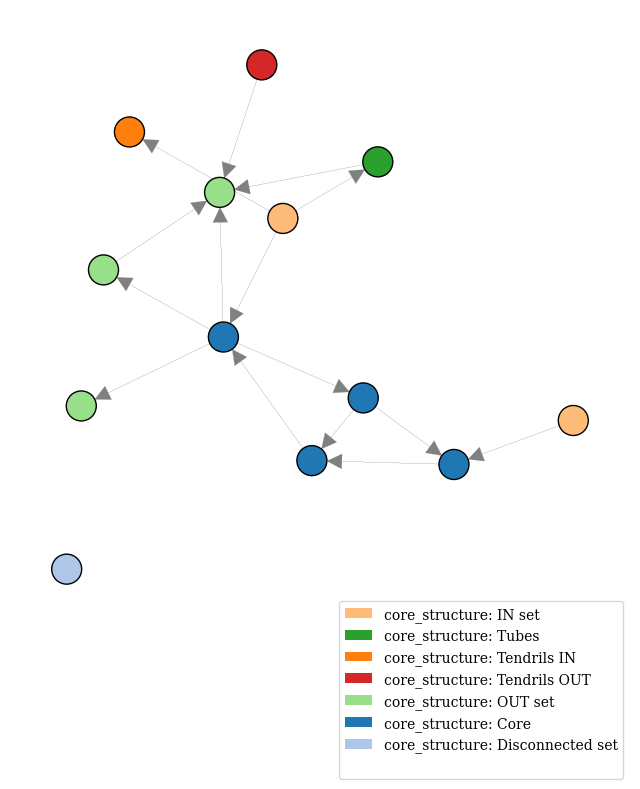

In [ ]:
#@title Test area core periphery structure

edges = [[0,1], [1,2], [2,4], [4,1], [4,0], [5,0], [6,2], [2,7], [2,8], [2,9], [8,9], [6,10], [10,9], [6,11], [12,9]]
G = ig.Graph(n=11, edges = edges, directed = True)
G.vs['name'] = [f'n{i}' for i in range(4)]
G.vs['ECO'] = [1 for i in range(4)]

core_preiphery_dict = get_bowtie_structure(G)
for key in core_preiphery_dict.keys():
  for node in core_preiphery_dict[key]:
    G.vs[node]['core_structure'] = key

fig, ax = plt.subplots(figsize = (8,8))
fig, ax = plot_graph(G, vertex_label_attribute=None, color_attribute = 'core_structure', target = ax)
fig.show()

In [ ]:
#@title Test area n_reachable_pairs
edges = [[0,2], [2,0], [2,1], [3,2], [1,2], [2,3], [3,1], [1,3]]
# edges = [[0,1], [1,2], [2,3], [3,0]]
G = ig.Graph(n=4, edges = edges, directed = True)
G.vs['name'] = [f'n{i}' for i in range(4)]
G.vs['ECO'] = [1 for i in range(4)]

node_removal_strategy(G, measure_v = lambda G, v: greedy_G_v(G, v, function = n_reachable_pairs))

['n2', 'n1', 'n0', 'n3']

# Data manipulations

In [ ]:
#@title Harmonization Core and Periphery
df = pd.read_pickle(network_bowtie_df_path)
df.reset_index(inplace = True)
df.columns = ['graph_name', 'Core', 'IN set', 'OUT set', 'Tendrils IN', 'Tendrils OUT', 'Tubes', 'Disconnected set']
graphs = df.graph_name.tolist()
vertices_count = []
for graph in graphs:
  i = index_from_dataset(G_dataset, graph)
  vertices_count.append(G_dataset[i].vcount())

df.set_index('graph_name')
df['Vertices count'] = vertices_count
for column in df.columns:
  if column != 'Vertices count' and column != 'graph_name':
    df[column] = df[column] * df['Vertices count']

column_order = ['graph_name', 'Core', 'IN set', 'OUT set', 'Tubes', 'Tendrils IN', 'Tendrils OUT', 'Disconnected set', 'Vertices count']
display(df[column_order])
df[column_order].to_pickle('/content/core_and_periphery_size.pickle')